# Predicción del precio futuro de ethereum

En esta sección estimamos los modelos de machine learning para 7 rezagos del precio de ethereum. En primer lugar, partimos de una regresión lineal para utilizarla como *benchmark*. Luego, realizamos una agrupación de predictoras mediante las componentes principales. Siguiendo el enfoque de modelos lineales, realizamos una estimación lasso para regularizar los coeficientes y ver si la predicción mejora. Una vez hecho esto, pasamos a los modelos no lineales. El primero es un estimador random forest, que ajusta múltiples árboles bajo la técnica de bagging. Después de random forest pasamos a un modelo de múltiples árboles que ajusta los datos mediante la técnica de boosting, conocido popularmente como xgboost. 



In [102]:
# generales
import pandas as pd 
import numpy as np # numpy y pandas to data wrangling 
from datetime import datetime, timedelta # to work w date
import statsmodels.api as sm
import math
from random import sample
from random import choices

# visualización
import matplotlib as mpl
import matplotlib.pyplot as plt

# métrica
from sklearn.metrics import mean_squared_error

# preprocesamiento
from sklearn.preprocessing import StandardScaler

# modelos
import xgboost as xgb
from sklearn.decomposition import PCA
import statsmodels.api as sm

In [103]:
# creamos la clase style para poner colores a los prints
class style():
    black = '\033[30m'
    red = '\033[31m'
    green = '\033[1;32m' # bold
    underline = '\033[4m'
    mark = '\33[44m'
    endc = '\033[0m'

In [104]:
# estilo de gráficos ggplot
plt.style.use('ggplot')

In [105]:
### Importamos bases y seteamos la variable Date como índice
# train
aux = 'https://drive.google.com/file/d/1JgC5z_ed0YfAjuiYxl9SqqPvgxX3-cZs/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
train = pd.read_csv(link)
train = train.set_index('Date')
# test
aux = 'https://drive.google.com/file/d/1GqALyVt4jKpkUoR2IbQJBvek4Y5rkEg-/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
test = pd.read_csv(link)
test = test.set_index('Date')
# target en train 
aux = 'https://drive.google.com/file/d/1qWQobNkMKTZah0hKhMWiiI1rDy89NaN6/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
y_train = pd.read_csv(link)
y_train = y_train.set_index('Date')
# target en test
aux = 'https://drive.google.com/file/d/1PhiVLaNQ3k7-XifEepwD4LoymDAmixix/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
y_test = pd.read_csv(link)
y_test = y_test.set_index('Date')

## Metodologías

### Regresión lineal 
Dado un vector de inputs $X^{T} = (X_1, X_2, ..., X_p)$, la regresión lineal predice el output $Y$ a través del siguiente modelo: 
$$
\hat{Y} = \hat{\beta_0} + \sum_{j=1}^{p}{X_{j}\hat{\beta_j}}
$$

El término $\hat{\beta_0}$ es el intercepto o término constante. Que podría ser incluido en el vector de coeficientes $\hat{\beta}$ agregando la variable 1 en $X$ para simplificar:

$$
\hat{Y} = X^{T}\hat{\beta}
$$

Donde $X^T$ es un vector o matriz transpuesta ($X$ como vector columna). Visto como una función sobre el espacio de inputs p-dimensional, $f(X)=X^{T}\beta$ es lineal y el gradiente $f^{'}(X) = \beta$ es un vector en el espacio de inputs que pondera a las variables $X$. 

Para ajustar la regresión lineal al conjunto de entrenamiento utilizamos el método de mínimos cuadrados ordinarios. Dicho enfoque, elige al conjunto de ponderadores $\beta$ que minimice la suma de los residuos al cuadrado:

$$
RSS(\beta)=\sum_{i=1}^{N}{(y_{i}-x_{i}^{T}\beta)^2}
$$

$RSS(\beta)$ es una función cuadrática de los parámetros, y por lo tanto su mínimo siempre existe, pero puede no ser único. Lo podemos escribir en notación matricial para facilitar la formalización: 

$$
RSS(\beta)=(Y-X\beta)^{T}(Y-X\beta)
$$

Donde $X$ es una matriz de $N x p$ siendo cada fila un vector de inputs, e $Y$ es un N-vector de los outputs en el subconjunto de entrenamiento. Diferenciando con respecto a $\beta$ obtenemos la ecuación normal 
$$
X^{T}(Y-X\beta)=0
$$

Si $X^{T}X$ es no singular, entonces la solución única está dada por: 
$$
\hat{\beta}=(X^{T}X)^{-1}X^{T}Y
$$
Y el valor ajustado en el i-ésimo input $x_i$ es $\hat{y_i}=x^{T}_{i} \hat{\beta}$. 

#### Forward stepwise selection
Dentro del método de regresión lineal resulta deseable encontrar el mejor subconjunto de variables predictoras que generen el mejor resultado en la predicción. Esto último implica no sólo encontrar el modelo que genere el mejor desempeño predictivo, sino también determinar si una menor cantidad de variables utilizadas podrían generar un modelo que tenga un poder predictivo similar a la estimación con todos los *features* incluidos. Para ello, se realiza un procedimiento de selección de variables conocido como *forward stepwise selection*, que comienza con un modelo sin predictores, y va agregando uno a la vez, hasta que todos los predictores estén dentro del modelo. El criterio de selección es a través de la raíz del error cuadrático medio como proporción de la media:
$$
\frac{RECM}{\overline{y}} = \frac{\sqrt{\frac{1}{N}\sum_{i=1}^{N}{(y_{i}-x_{i}^{T}\beta)}}}{\overline{y}}
$$ 
El hecho de poner la métrica como proporción de la media del target es para tener una magnitud del error interpretable y que pueda medirse de manera relativa a la magnitud del promedio de $y$. Cabe destacar que dicha métrica será utilizada para evaluar el desempeño de predicción de todos los modelos bajo estudio.

La variable que genera el menor error de predicción es seleccionado. Para dicha evaluación se separa un subconjunto dentro de entrenamiento, denominado *validación*, el cual corresponde a los datos del año 2020 y no son utilizados para ajustar el modelo. Una vez incluido el predictor, el proceso de selección se repite condicionado en que la variable elegida antes se mantiene dentro del modelo. Como se mencionó antes, este proceso finaliza cuando se incluyen todos los predictores en el modelo. 

### Extreme gradient boosting (xgboost)
La técnica de *Boosting* es una de las ideas de aprendizaje más eficaces de los últimos 20 años, cuya motivación ha sido la búsqueda de un procedimiento que combine *outputs* de muchos clasificadores "débiles" para producir un potente estimador agregado. Dentro de este enfoque predictivo, Extreme Gradient Boosting (XGBoost) es reconocido como un algoritmo de amplio uso por su capacidad predictiva excepcional. La idea principal de este algoritmo es que el mismo construye *D* árboles de clasificación (CART) uno por uno, tal que el modelo subsecuente es entrenado utilizando el residual del árbol previo (*decision tree ensembles*). Esto es, el nuevo árbol corrige los errores hechos por el árbol previamente entrenado y predice nuevamente el *outcome*. 
Así, en XGBoost cada modelo ensamblado utiliza la suma de las *D* funciones para predecir el output.
$$
\hat{Y}_i=\sum_{d=1}^{D}f_{d}(X_i),f_{d}\in F, i=1,...,N 
$$
Donde $F$ es el conjunto de todos los modelos CART posibles, y cada $f_{d}$ representa una estructura de árbol independiente que es denotada como $q$. Esto es, $q$ representa el conjunto de reglas de un modelo que clasifica cada individuo $i$ en un nodo final. La fase de entrenamiento implica clasificar $N$ observaciones tal que, dado las variables $X$, cada nodo final tenga un *score* que corresponda a la proporción de casos que son clasificados dentro de la ocurrencia del evento para esa combinación específica de $X_i$. Se denota al *score* como $w_{q(X)}$.

Luego, $q$ puede escribirse como una función $q:\mathbb{R}^{P}\longrightarrow T$, donde $T$ es el número total de nodos finales de un árbol y $j$ denota un nodo final individual, $j=1,...,T$. Para calcular la predicción final para cada individuo, el *score* de los nodos finales se suman mediante la Ecuación anterior, donde $F=\lbrace f(x)=w_{q(X)}\rbrace$ con $q:\mathbb{R}^{P}\longrightarrow T$ y $w \in \mathbb{R}^T$.

En general los métodos de *boosting* ajustan cada árbol a través de versiones re-ponderadas. La ponderación es un mecanismo que penaliza las predicciones incorrectas de los modelos anteriores, con el objetivo de mejorar la predicción. Así, la estructura de ponderadores son generalmente valores óptimos, que son ajustados una vez que la función de pérdida es minimizada. Por lo que los nuevos modelos incorporan la nueva estructura de ponderación en cada iteración, y predice un nuevo *outcome*.

La función a ser optimizada está dada por 
$$
\mathcal{L}=\sum_{i=1}^{N} l(y_i,\hat{y}_i)+\sum_{d=1}^{D}\Omega(f_d)
$$

donde $l$ es una función de pérdida convexa diferenciable que mide la diferencia entre la predicción $\hat{y}_i$ y la dependiente $y_i$. Mientras que el segundo término es el componente que penaliza la complejidad de las funciones creadas por XGBoost. Intuitivamente, la función objetivo regularizada tenderá a seleccionar aquel modelo que provea funciones predictivas y simples.

Finalmente, además de la penalización de complejidad, en *Extreme Gradient Boosting* existen una amplia variedad de otros hiperparámetros que se deben elegir previo a la ejecución del algoritmo. A continuación se listan los más comunes a establecer:


- **nrounds**: número de árboles. Rango $[0,\infty)$.
- **max_depth**: profundidad máxima de los árboles. Rango $[0,\infty]$.
- **eta**: proporción a la que el árbol aprende. Rango $[0,1]$.
- **gamma**: mínima reducción del error para generar un corte. Rango $[0,\infty]$.
- **colsample_bytree**: variables a muestrear y considerar en cada árbol. Rango $[0,1]$.
- **min_child_weight**: mínima cantidad de observaciones en los nodos finales para considerar un corte. Rango $[0,\infty]$.
- **subsample**: muestreo de observaciones a considerar en cada árbol. Rango $[0,1]$.

Para realizar la estimación en XGBoost realizamos los siguientes pasos. En primer lugar, volvemos a cargar las bases que necesitamos para realizar el ejercicio de predicción; luego creamos una función *custom* para aplicar el método de *random search* con un enfoque de validación ya utilizado denomicado *Time Series Split 10-Cross-Validation*. El mejor modelo de dicha estimación es evaluado en el grupo *test*. 

## Resultados

#### Regresión lineal 
La sección se estructura de la siguiente manera. En primer lugar, ajustamos y evaluamos la performance del modelo, utilizando una separación básica de train y test siguiendo el enfoque de validación. Luego, realizamos un *time split cross-validation* para evaluar las características de la separación inicial de train y test. Por último, realizamos el método de selección *forward stepwise selection* para analizar si el modelo podría mejorar a partir de la reducción de columnas del dataset. Cabe aclarar que todas las pruebas se realizan sobre los siete rezagos bajo estudio.

##### Entrenamiento del modelo 

En primer lugar, entrenamos un modelo de regresión lineal para cada uno de los rezagos bajo estudio y computamos la bonda de ajuste a través del $R^2$. 

In [106]:
# agregamos el término constante al dataset de train y test
x_train = sm.add_constant(train)
x_test = sm.add_constant(test, has_constant='add')
# computamos el R2 para cada lag 
r_squaredAdj = []
for i in range(1,len(y_train.columns)+1):
  model = sm.OLS(y_train.loc[:,f'log_y_lag{i}'], x_train.astype(float)).fit()
  r_squaredAdj = r_squaredAdj + [round(model.rsquared, 4)]
print(f'R2_lag1: {style.green}{r_squaredAdj[0]}{style.endc} R2_lag2: {style.green}{r_squaredAdj[1]}{style.endc} R2_lag3: {style.green}{r_squaredAdj[2]}{style.endc} R2_lag4: {style.green}{r_squaredAdj[3]}{style.endc}')
print(f'R2_lag5: {style.green}{r_squaredAdj[4]}{style.endc} R2_lag6: {style.green}{r_squaredAdj[5]}{style.endc} R2_lag7: {style.green}{r_squaredAdj[6]}{style.endc}')

R2_lag1: 0.9998 R2_lag2: 0.9989 R2_lag3: 0.998 R2_lag4: 0.9971
R2_lag5: 0.9962 R2_lag6: 0.9953 R2_lag7: 0.9945


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Como se puede ver arriba, el ajuste es casi 1, y disminuye a medida que nos alejamos en el tiempo, lo cual podría ser indicio de que la verdadera relación entre el target y los predictores se acerca a una asociación lineal, pero la dificultad en la predicción aumenta a medida que nos alejamos en el tiempo. A continuación, visualizamos la salida de regresión sólo para el caso del ajuste en el primer rezago. 

In [107]:
# ajuste lineal para el primer rezago
model = sm.OLS(y_train.iloc[:,0], x_train.astype(float)).fit()
 
# visualización de la salida de regresión
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_y_lag1   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.595e+05
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:58:52   Log-Likelihood:                 5865.2
No. Observations:                1956   AIC:                        -1.163e+04
Df Residuals:                    1906   BIC:                        -1.135e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

En la salida de regresión de arriba se observan variables significativas esperables, como el precio de ethereum y de bitcoin del día corriente y anterior al corriente. En el caso de ethereum, la correlación parcial es positva, interpretándose que un aumento del 1% del precio actual de ethereum se correlaciona, ceteris paribus, con un aumento del 0.99% del precio de ethereum del día siguiente. Mientras que en caso del bitcoin existen dos efectos significativos: el del día corriente y del día anterior al actual. Un aumento del 1% del precio corriente de bitcoin se asocia con una caída del 0.8% del precio de ethereum del día siguiente. No obstante, un aumento del 1% del precio de bitcoin del día anterior al actual se correlaciona con un aumento del 0.84% del valor de ethereum. Resulta interesante como se contraponen ambos efectos. Si lo analizaramos en sentido estático y dejando todo lo demás constante, un aumento del precio de bitcoin en el día actual, seguido de un aumento de la misma criptomoneda en el día anterior, ambas de la misma variación porcentual, se correlacionaría con un leve aumento del precio de ethereum. Ambos efectos jugarían como un rol de sustituto (bitcoin en el día actual) por un lado y complementario (bitcoin del día anterior al actual), por el otro, del valor del siguiente día de ethereum.   

El bucle anterior extrae de cada regresión entre el valor de ethreum de difentes momentos en el tiempo el R2 ajustado, partiendo desde el primer rezago hasta el séptimo. El ajuste, si bien disminuye al ajustar un modelo que estima momentos más lejanos en el tiempo, sigue siendo considerablemente alto en todas las instancias. 

##### Evaluación de performance

**Subconjunto de entrenamiento** 

Primero evaluamos la performance predictiva en el grupo de entrenamiento para cada rezago utilizado como target, siendo conscientes del probable sobreajuste que esta evaluación genere. Para realizar la evaluación de desempeño del modelo utilizamos la métrica antes mencionada ($\frac{RECM}{\overline{y}}$). Los resultados se pueden ver en el siguiente `print()`:

In [108]:
# computamos el predicho para cada uno de los rezagos de la dependiente
predictions_dict = {}
for i in range(1,len(y_train.columns)+1):
  model = sm.OLS(y_train.loc[:,f'log_y_lag{i}'], x_train.astype(float)).fit()
  predictions = model.predict()
  predictions_dict[f'pred_y_lag{i}'] = predictions
  mse = mean_squared_error(y_train.loc[:,f'log_y_lag{i}'], 
                          predictions_dict[f'pred_y_lag{i}'])
  rmse = math.sqrt(mse)
  mean_target_train = y_train.loc[:,f'log_y_lag{i}'].mean()
  print(f"{style.underline}Raíz del error cuadrático medio para log_y_lag{i}{style.endc}:")
  print(f'El error de predicción en el grupo de entrenamiento es equivalente al {style.green}{round(rmse/mean_target_train*100, 2)}%{style.endc} del promedio de la variable dependiente\n')

Raíz del error cuadrático medio para log_y_lag1:
El error de predicción en el grupo de entrenamiento es equivalente al 0.62% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag2:
El error de predicción en el grupo de entrenamiento es equivalente al 1.34% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag3:
El error de predicción en el grupo de entrenamiento es equivalente al 1.77% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag4:
El error de predicción en el grupo de entrenamiento es equivalente al 2.12% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag5:
El error de predicción en el grupo de entrenamiento es equivalente al 2.43% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag6:
El error de predicción en el grupo de entrenamiento es equivalente al 2.69% del promedio de la variable dependiente

Raíz

Como es esperable, el ajuste es considerablemente alto, por lo que la predicción también lo es. Aunque la performance disminuye a medida que predecimos valores más lejanos.

**Subconjunto test**
 
Pasamos a evaluar la performance en el grupo test. La misma se muestra en el siguiente `print()`: 

In [109]:
# computamos la performance de la regresión lineal en test
predictions_test_dict = {}
for i in range(1,len(y_test.columns)+1):
  model = sm.OLS(y_train.loc[:,f'log_y_lag{i}'], x_train.astype(float)).fit()
  predictions = model.predict(x_test)
  predictions_test_dict[f'pred_y_lag{i}'] = predictions
  mse = mean_squared_error(y_test.loc[:,f'log_y_lag{i}'], 
                          predictions_test_dict[f'pred_y_lag{i}'])
  rmse = math.sqrt(mse)
  mean_target_test = y_test.loc[:,f'log_y_lag{i}'].mean()
  print(f"{style.underline}Raíz del error cuadrático medio para log_y_lag{i} en test{style.endc}:")
  print(f'El error de predicción es equivalente al {style.green}{round(rmse/mean_target_test*100,2)}%{style.endc} del promedio de la variable dependiente\n')

Raíz del error cuadrático medio para log_y_lag1 en test:
El error de predicción es equivalente al 0.36% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag2 en test:
El error de predicción es equivalente al 0.84% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag3 en test:
El error de predicción es equivalente al 1.19% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag4 en test:
El error de predicción es equivalente al 1.5% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag5 en test:
El error de predicción es equivalente al 1.8% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag6 en test:
El error de predicción es equivalente al 2.03% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag7 en test:
El error de predicción es equivalente al 2.24% del promedio de la variable 

Curiosamente, la performance predictiva tiene mejoras en el grupo test respecto a la evaluación en el grupo de entrenamiento. A continuación, pasamos a graficar el observado versus el predicho para cada target estimado en plots de nubes de puntos.

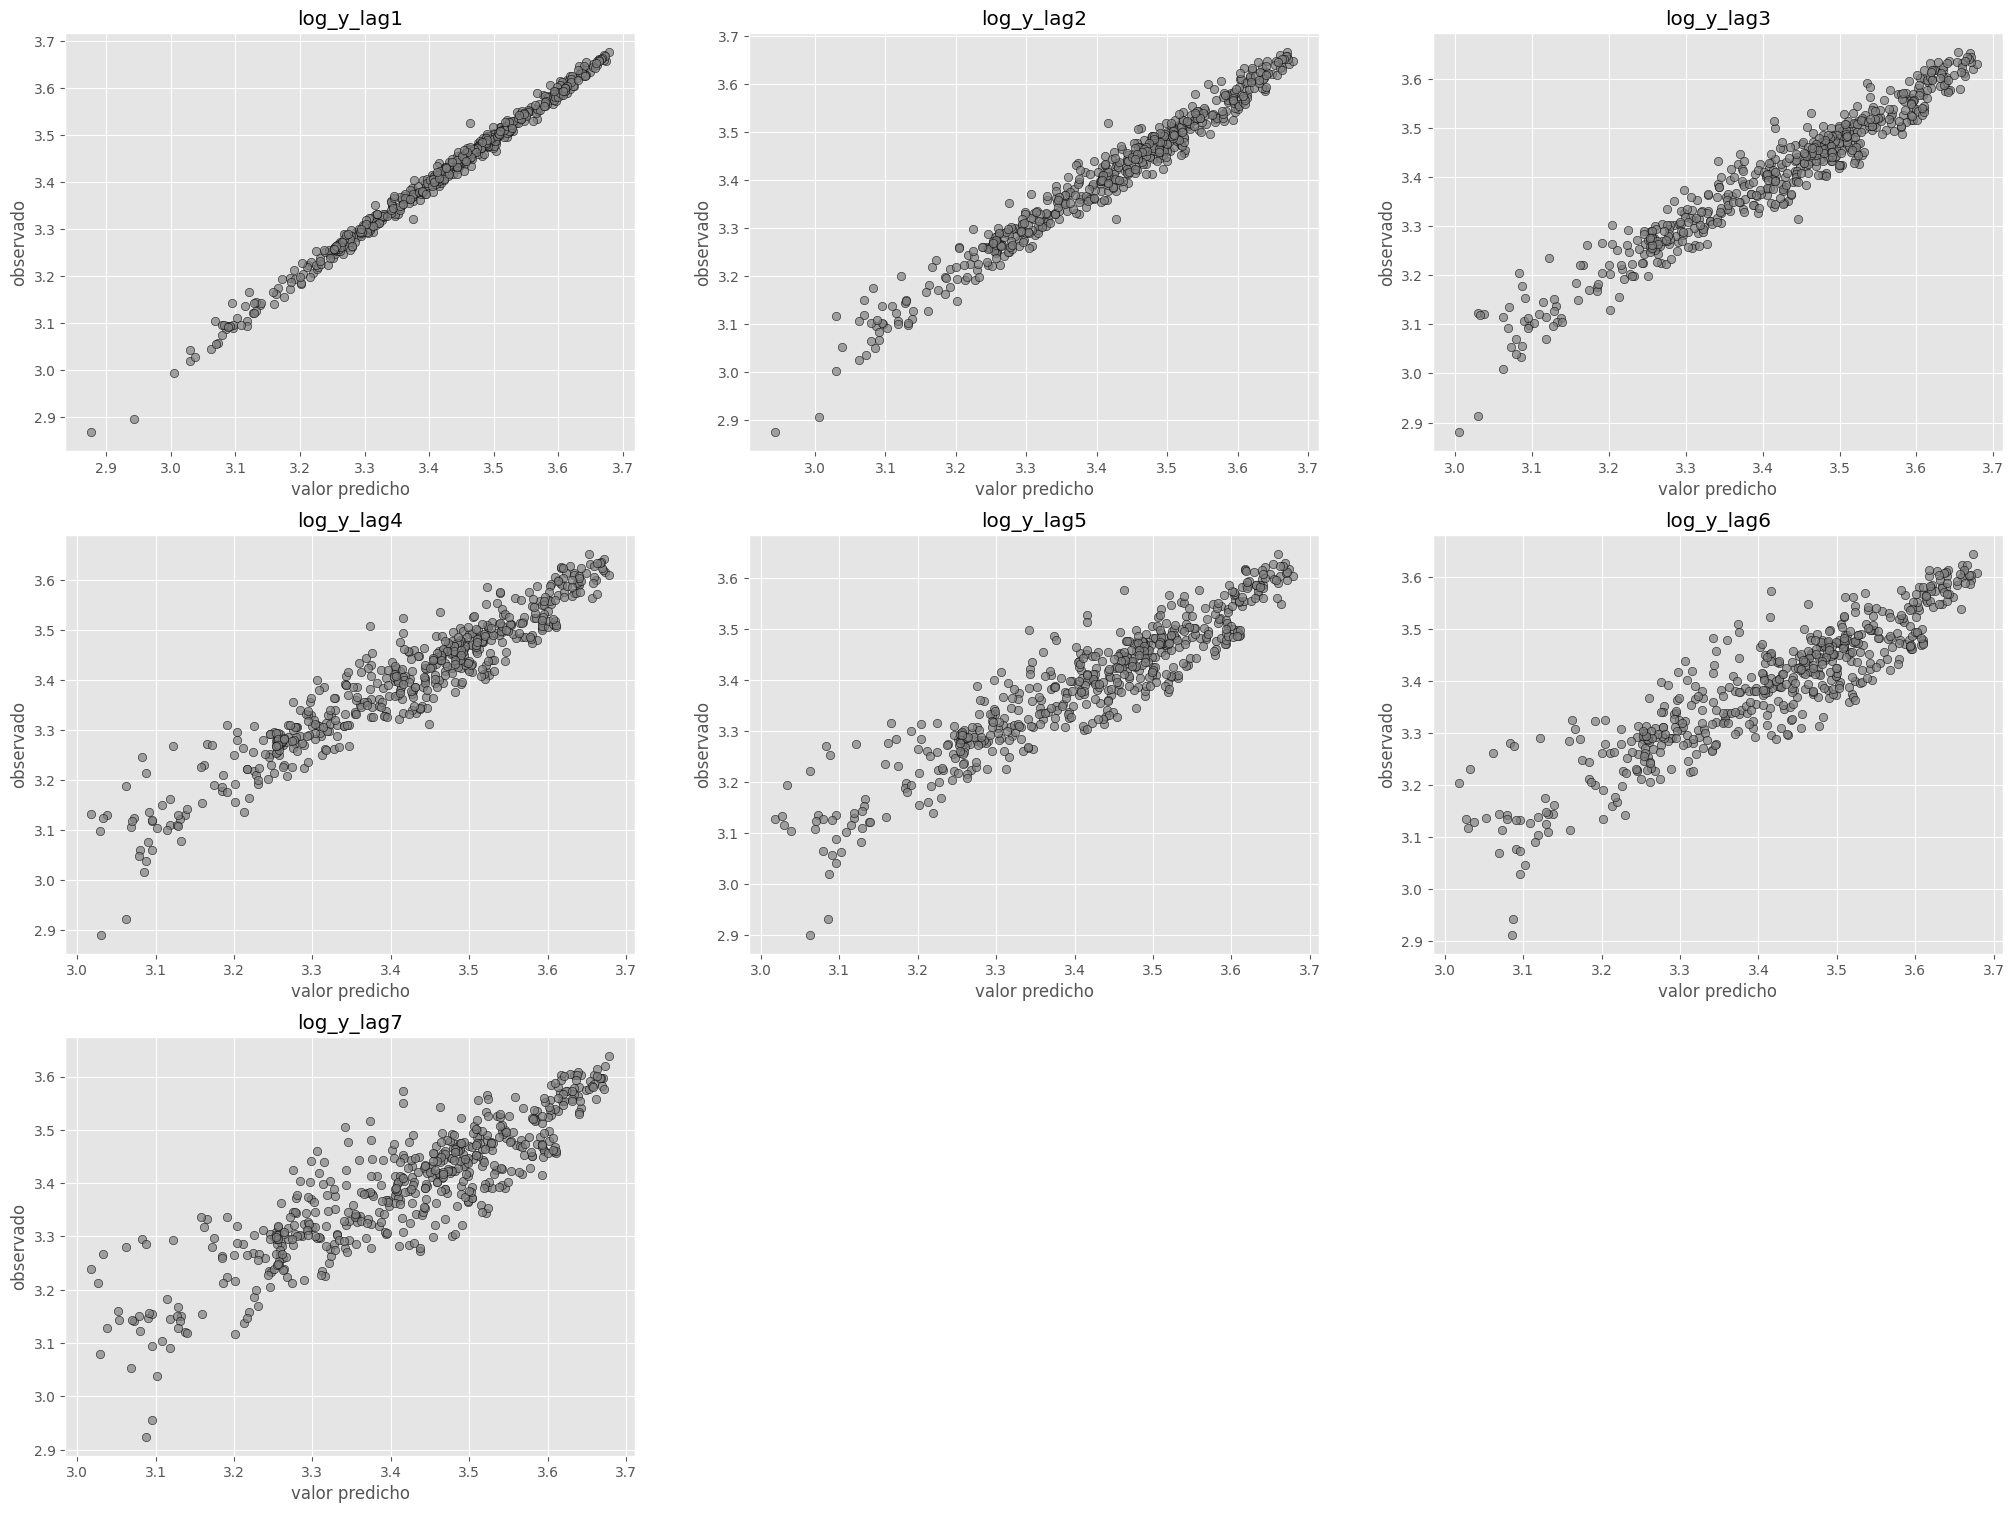

In [110]:
fig=plt.figure(figsize=(25,25))
for i in range(0,7):
    ax=fig.add_subplot(4,3, i+1)
    ax.scatter(y_test.loc[:,f'log_y_lag{i+1}'], 
               predictions_test_dict[f'pred_y_lag{i+1}'], 
               edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
    plt.title(f'log_y_lag{i+1}')
    plt.xlabel("valor predicho")
    plt.ylabel("observado")

La disminución en el poder predictivo del modelo se puede ver en el aumento de dispersión de los gráficos mostrados arriba. A medida que el target a predecir es más lejano en el tiempo el error de predicción aumenta, también lo podemos ver al considerar el tiempo en gráficos de línea como se muestra debajo:

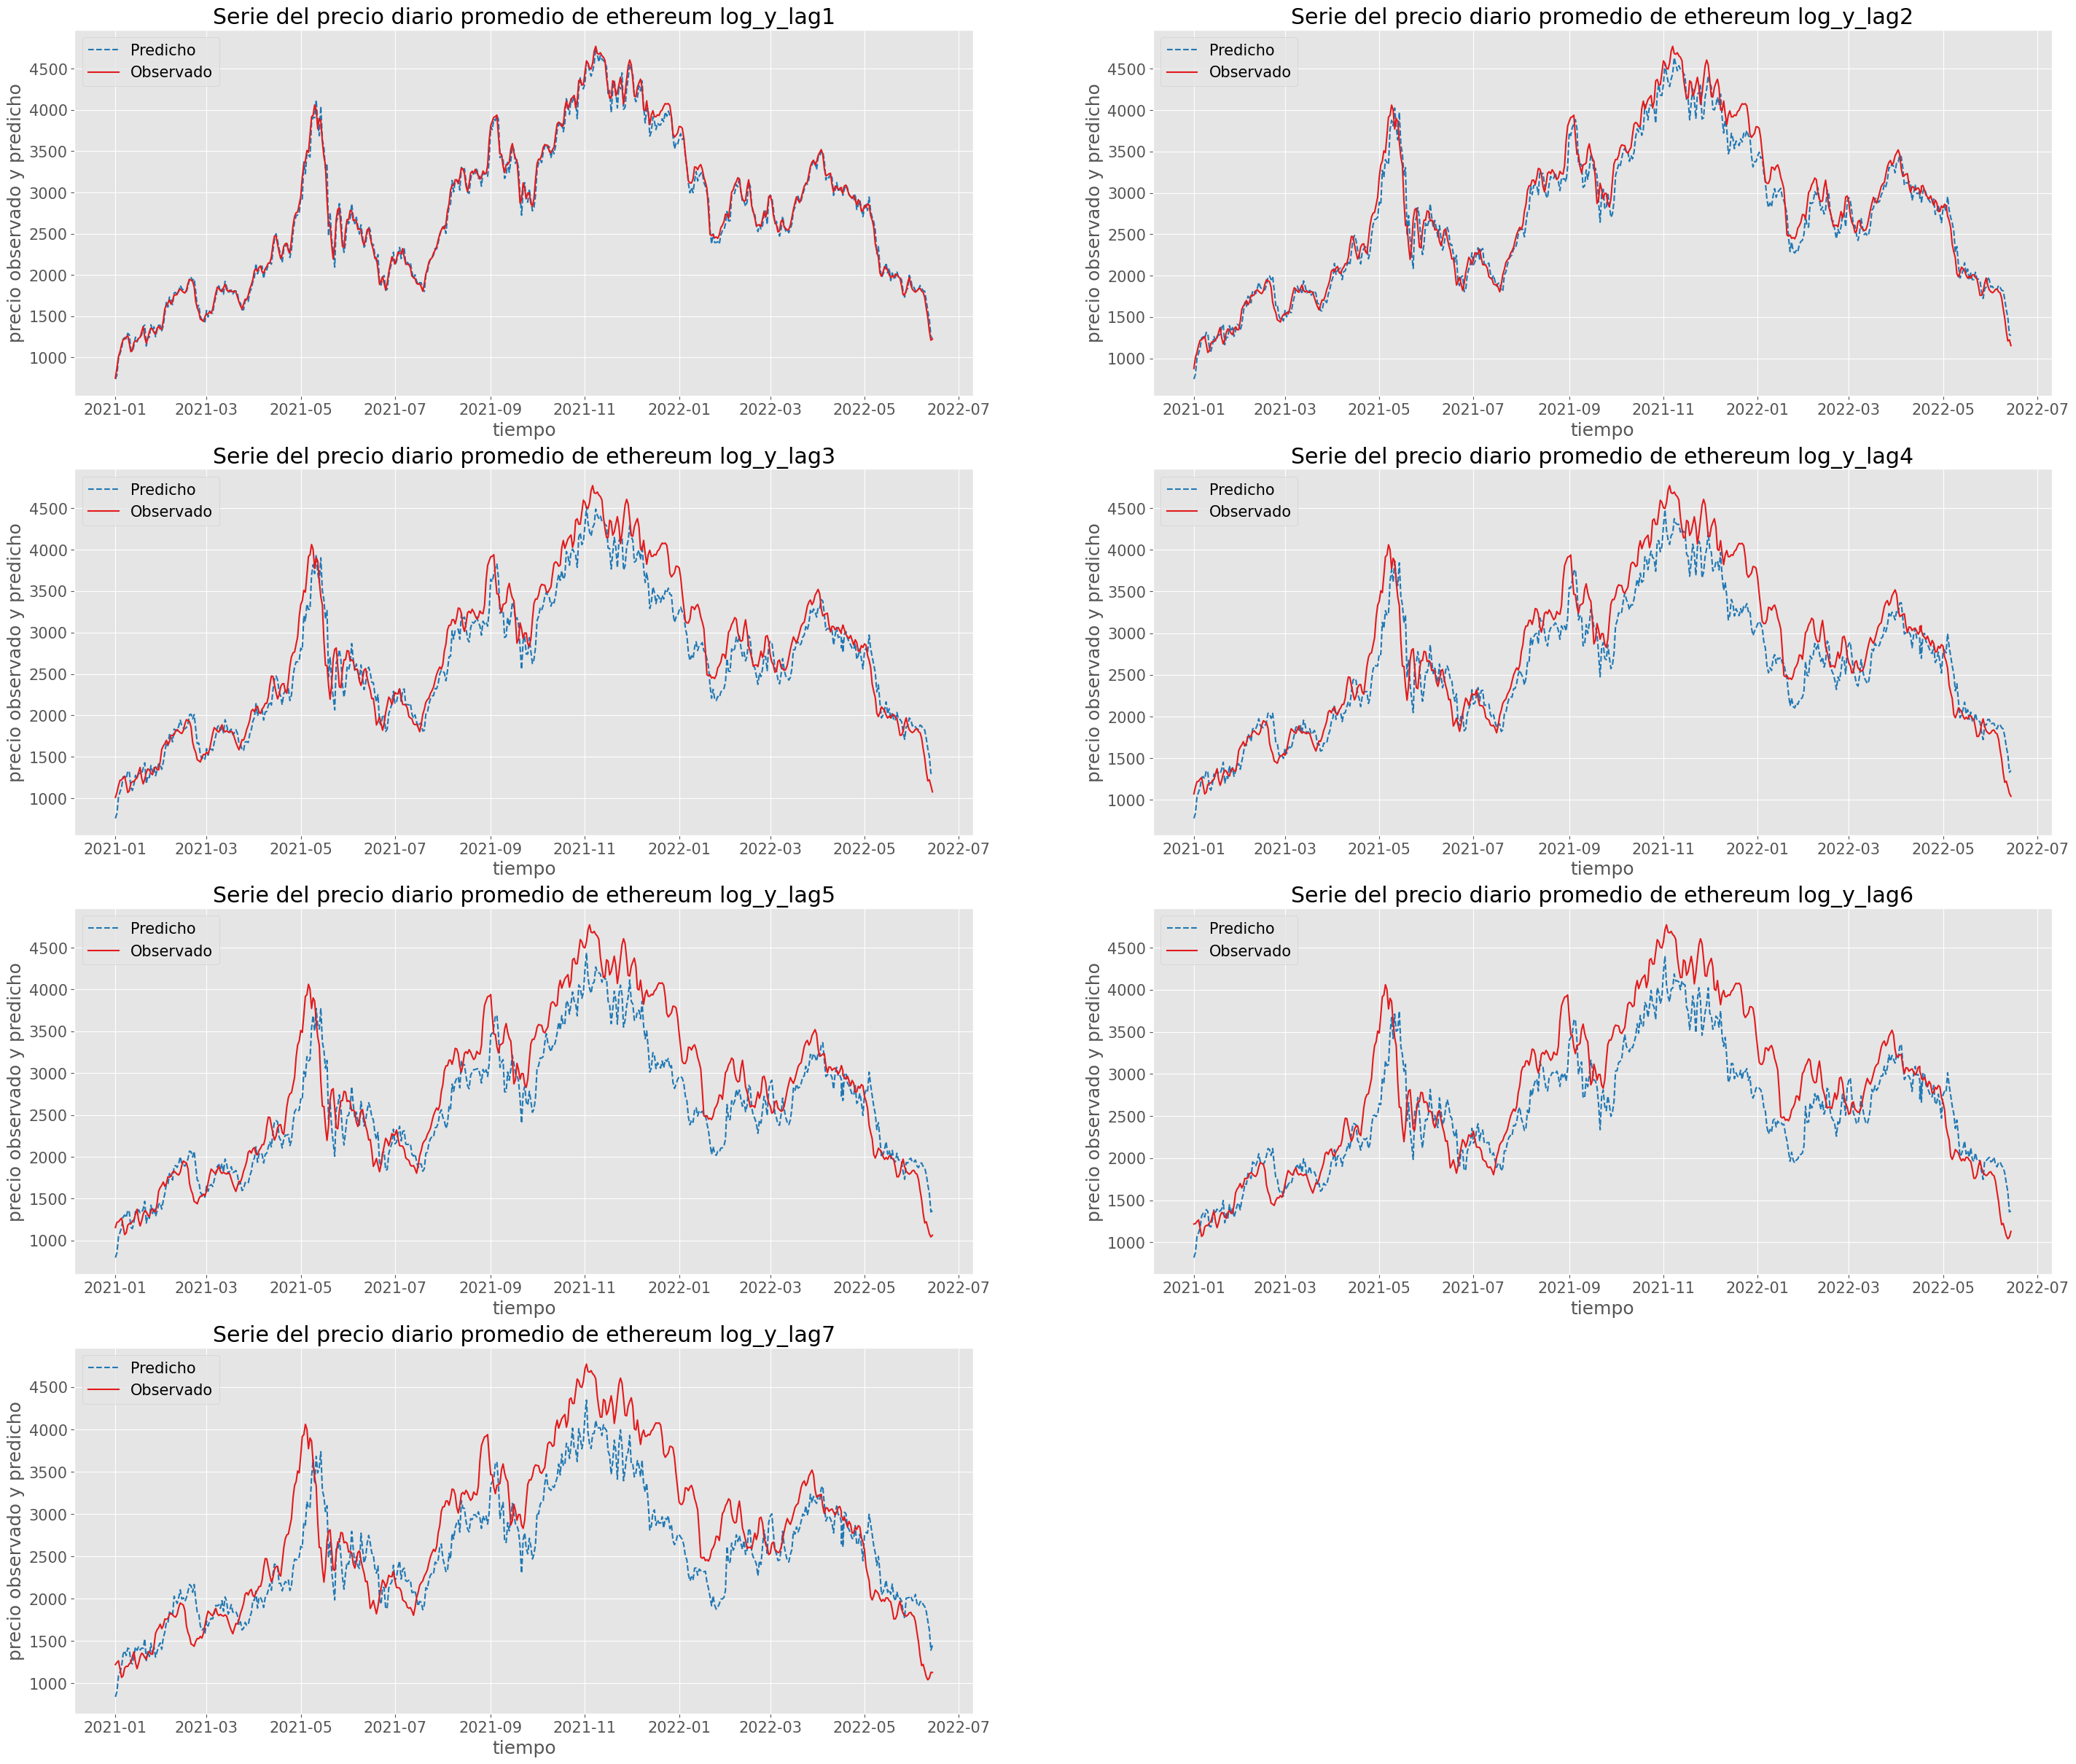

In [111]:
## graficamos el predicho versus el observado en cotizaciones
mpl.rcParams.update({'font.size': 15}) # set tamaño de ticks

fig=plt.figure(figsize=(35,30))
for i in range(0,7):
    pred_exp = 10**(predictions_test_dict[f'pred_y_lag{i+1}'])
    observ_exp = 10**(y_test.loc[:,f'log_y_lag{i+1}'])
    pred_exp.index = pd.to_datetime(pred_exp.index)
    observ_exp.index = pd.to_datetime(observ_exp.index)
    ax=fig.add_subplot(4,2, i+1)
    ax.plot(pred_exp, color='#1f78b4', label = 'Predicho', linestyle="--")
    ax.plot(observ_exp , color='#e31a1c', label = 'Observado')
    plt.ylabel("precio observado y predicho")
    plt.xlabel("tiempo")
    plt.title(f'Serie del precio diario promedio de ethereum log_y_lag{i+1}')
    plt.legend(loc="upper left");

El predicho del primer rezago, es decir, del día siguiente es casi idéntico al valor observado. A medida que intentamos predecir ventanas de tiempo más alejadas el error aumenta. Sin embargo, el modelo lineal en la mayoría de casos subestima el precio real, lo cual es preferible: la predicción de un aumento del precio de ethereum en el mismo día de la siguiente semana sería una cota inferior, lo que significa que ese aumento puede ser aún mayor, lo mismo con la magnitud de una futura caída predicha. 

Estos resultados podrían estar asociadas a la oportuna separación entre entrenamiento y test, por lo que a continuación realizamos un ejercicio de *cross-validation* en entrenamiento para ver si en otros intervalos de tiempo se producen desempeños de predicción similares o nuestros resultados iniciales se debieron a la oportune *split* de datos. 

##### Time Series Split Cross-Validation
Pasamos a realizar el análisis de validación cruzada con todos los rezagos bajo estudio. 

In [112]:
# función para fragmentar intervalo de tiempo en grupos de aproximadamente el mismo rango
def date_range(start, end, intv):
    start = datetime.strptime(start,"%Y-%m-%d")
    end = datetime.strptime(end,"%Y-%m-%d")
    diff = (end  - start ) / intv
    for i in range(intv):
        yield (start + diff * i).strftime("%Y-%m-%d")
    yield end.strftime("%Y-%m-%d")

In [113]:
# fragmentamos el grupo train
lower = x_train.index[0]
upper = x_train.index[-1]
timelist = list(date_range(lower, upper, 11))
timelist

['2015-08-17',
 '2016-02-11',
 '2016-08-07',
 '2017-02-02',
 '2017-07-30',
 '2018-01-25',
 '2018-07-22',
 '2019-01-17',
 '2019-07-14',
 '2020-01-09',
 '2020-07-05',
 '2020-12-31']

In [114]:
# realizamos la rutina de cross-validation para cada uno de los rezagos
rmse_matrix_train_dict = {}
rmse_matrix_valid_dict = {}

for j in range(1,len(y_train.columns)+1):
  rmse_matrix_train = []
  rmse_matrix_valid = []
  print(f"{style.underline}Estimation over log_y_lag{j}{style.endc}:")
  for i in range(1, len(timelist)-1):
    # momento inicial (siempre fijo)
    first = timelist[0]
    # momento final (va aumentando para acumular los grupos)
    last = timelist[i]
    # momento inicial para validación (1 día después del momento final train)
    aux = datetime.strptime(last,"%Y-%m-%d") + timedelta(days=1)
    first_valid = aux.strftime("%Y-%m-%d")
    # momento final validación (siguiente fecha al momento final train)
    last_valid = timelist[i+1]
    print(f'Iteration {i} working on range of date {first} to {last} (training) to predict range {first_valid} to {last_valid}')
    # creamos los subconjuntos train y validación
    x_train_cv = x_train[first:last]
    x_valid_cv = x_train[first_valid:last_valid]
    y_train_cv = y_train.loc[first:last,f'log_y_lag{j}']
    y_valid_cv = y_train.loc[first_valid:last_valid,f'log_y_lag{j}']
    # ajustamos el modelo con los nuevos subconjuntos
    model_cv = sm.OLS(y_train_cv, x_train_cv.astype(float)).fit()
    # Predicción en validación
    predictions_train_cv = model.predict(x_train_cv)
    mse_train_cv = mean_squared_error(y_train_cv, predictions_train_cv)
    rmse_train_cv = math.sqrt(mse_train_cv)
    mean_target_cv_train = y_train_cv.mean()
    metric_error_train = rmse_train_cv/mean_target_cv_train*100
    rmse_matrix_train.append(metric_error_train)
    # prueba en observaciones del grupo dejado afuera
    predictions_valid_cv = model.predict(x_valid_cv)
    mse_valid_cv = mean_squared_error(y_valid_cv, predictions_valid_cv)
    rmse_valid_cv = math.sqrt(mse_valid_cv)
    mean_target_cv = y_valid_cv.mean()
    metric_error_valid = rmse_valid_cv/mean_target_cv*100
    print(f'  El error de predicción representa el {style.green}{round(metric_error_train, 2)}%{style.endc} de la media en entrenamiento y el {style.green}{round(metric_error_valid, 2)}%{style.endc} en validación\n')
    rmse_matrix_valid.append(metric_error_valid)
  rmse_matrix_train_dict[f'log_y_lag{j}'] = rmse_matrix_train
  rmse_matrix_valid_dict[f'log_y_lag{j}'] = rmse_matrix_valid
  

Estimation over log_y_lag1:
Iteration 1 working on range of date 2015-08-17 to 2016-02-11 (training) to predict range 2016-02-12 to 2016-08-07
  El error de predicción representa el 8.76% de la media en entrenamiento y el 2.67% en validación

Iteration 2 working on range of date 2015-08-17 to 2016-08-07 (training) to predict range 2016-08-08 to 2017-02-02
  El error de predicción representa el 4.05% de la media en entrenamiento y el 2.83% en validación

Iteration 3 working on range of date 2015-08-17 to 2017-02-02 (training) to predict range 2017-02-03 to 2017-07-30
  El error de predicción representa el 3.52% de la media en entrenamiento y el 2.38% en validación

Iteration 4 working on range of date 2015-08-17 to 2017-07-30 (training) to predict range 2017-07-31 to 2018-01-25
  El error de predicción representa el 3.09% de la media en entrenamiento y el 1.27% en validación

Iteration 5 working on range of date 2015-08-17 to 2018-01-25 (training) to predict range 2018-01-26 to 2018-07-

In [115]:
# vemos los resultados de la predicción en cada grupo dejado como validación para cada rezago
for j in range(1,len(y_train.columns)+1):
    print(f'{style.underline}log_y_lag{j}{style.endc}:')
    print(rmse_matrix_valid_dict[f'log_y_lag{j}'])

log_y_lag1:
[2.6698652170282227, 2.8271036321287215, 2.3755097177350826, 1.2721756363153298, 1.0441308767502648, 1.0106221464557574, 0.7861127194193654, 0.9151039248647633, 1.5868058178488293, 1.1170808461908897]
log_y_lag2:
[3.7915444756328993, 2.9694023678120023, 2.6350660116583504, 1.4679337916378277, 1.2316604620476288, 1.305693194709171, 1.053534661985444, 1.1207658027149738, 1.650100426776629, 1.2327436058172931]
log_y_lag3:
[4.626102129258907, 3.0706013055306505, 2.9178290474421402, 1.6719671328390484, 1.3618665762557611, 1.5745548016329307, 1.2785899432788883, 1.2509768338345375, 1.7657029305866816, 1.356079598686667]
log_y_lag4:
[5.415845190518675, 3.216647451216058, 3.207304741219435, 1.846834123911709, 1.4841385055700724, 1.8829542967921915, 1.5153731223488098, 1.3603863178916662, 1.865512555217673, 1.508600224495309]
log_y_lag5:
[6.050748461170035, 3.424784469530954, 3.5544053043619748, 1.9734790525427863, 1.6076717402565321, 2.1562668089040415, 1.7472369885737953, 1.455902

Como se puede ver a partir de los resultados de arriba, hay una mejora a medida que nos acercamos a períodos actuales. Esto podría deberse a dos cuestiones: en primer lugar, la técnica de acumular observaciones al grupo de entrenamiento va generando un mejor aprendizaje por parte del modelo lineal, por lo que el error de predicción disminuye a medida que más observaciones forman parte del input para ajustar la regresión; en segundo lugar, períodos cercanos a los inicios de la cotización de ethereum poco están relacionados a su popularidad y por tanto a las decisiones de la oferta y demanda masiva que se intenta captar a partir de los datos de búsquedas en google, por lo que a medida que nos acercamos a períodos actuales los términos de búsquedas se asocian en mayor medida a los movimientos del precio de la criptomoneda, lo cual se ve reflejado en mejores resultados de predicción en fechas cercanas al momento actual. De todas formas, el patrón de mejor predicción en validación se sigue cumpliendo, por lo que se descarta de que la misma este condicionada en el corte de tiempo para dividir el conjunto de datos. A continuación, pasamos a promediar los resultados mostrados antes:

In [116]:
# función para promediar listas
def Average(lst):
    return sum(lst) / len(lst)

# promediamos los errores en validación de cada iteración
for j in range(1,len(y_train.columns)+1):
    mean_error_cv_valid = Average(rmse_matrix_valid_dict[f'log_y_lag{j}'])
    print(f'En promedio, la predicción del log_y_lag{j} arroja un error del {style.green}{round(mean_error_cv_valid, 2)}%{style.endc} en validación')

En promedio, la predicción del log_y_lag1 arroja un error del 1.56% en validación
En promedio, la predicción del log_y_lag2 arroja un error del 1.85% en validación
En promedio, la predicción del log_y_lag3 arroja un error del 2.09% en validación
En promedio, la predicción del log_y_lag4 arroja un error del 2.33% en validación
En promedio, la predicción del log_y_lag5 arroja un error del 2.56% en validación
En promedio, la predicción del log_y_lag6 arroja un error del 2.77% en validación
En promedio, la predicción del log_y_lag7 arroja un error del 2.98% en validación


De lo anterior encontramos que la regresión lineal arroja un desempeño muy competitivo, cuyo error de predicción va aumentando a medida que intentamos estimar precios más alejados en el tiempo. A su vez, los resultados mejoran al evaluar la performance en validación, por lo que ocurre lo contrario al sobreajuste, y no parece estar asociado a la fecha de corte para separar los datos en entrenamiento y validación/test. A continuación, realizamos el ejercicio de selección explicado anteriormente, conocido como *forward stepwise selection*, con el objetivo de ver qué variables son las más importantes en la predicción, como también, si la predicción se puede mejorar o no al reducir la dimensión del dataset, a través de la selección del subconjunto de variables más importantes para predecir el precio futuro de ethereum. 

##### Forward stepwise selection

In [117]:
# realizamos la rutina de selección para cada rezago
output_dict = {} 
for j in range(1,len(y_train.columns)+1):
  print(f'{style.underline}log_y_lag{j}{style.endc}:')
  # x_test_step = sm.add_constant(test)
  candidates = list(train.columns)

  seleccionado = []
  # output_df = pd.DataFrame(d)
  train_step = sm.add_constant(train[train.index[0]:'2019-12-31'], has_constant='add')
  valid_step = sm.add_constant(train['2020-01-01':], has_constant='add')
  y_train_step = y_train[train.index[0]:'2019-12-31']
  y_valid_step = y_train['2020-01-01':]
  # baseline
  model_baseline = sm.OLS(y_train_step.loc[:,f'log_y_lag{j}'], train_step.loc[:,'const'].astype(float)).fit()
  # predicción
  predictions_test_baseline = model_baseline.predict(valid_step.loc[:,'const'])
  # métrica
  mse_test_baseline = mean_squared_error(y_valid_step.loc[:,f'log_y_lag{j}'], predictions_test_baseline)
  rmse_test_baseline = (math.sqrt(mse_test_baseline)/y_valid_step.loc[:,f'log_y_lag{j}'].mean())*100
  # df
  d = {'var': ["constant"], 'rmse': [rmse_test_baseline]}
  output_df = pd.DataFrame(data=d)

  # selección
  c = 0
  while len(candidates) > 0:
    max_rmse = float('inf') 
    for v in candidates:
      # agregar constante
      l =  seleccionado + [v] + ['const']
      # subset
      x_train_step = train_step.loc[:, l]
      x_valid_step = valid_step.loc[:, l]
      
      # ajuste lineal
      model_step = sm.OLS(y_train_step.loc[:,f'log_y_lag{j}'], x_train_step.astype(float)).fit()
      # predicción
      predictions_test_step = model_step.predict(x_valid_step)
      # métrica
      mse_test_step = mean_squared_error(y_valid_step.loc[:,f'log_y_lag{j}'], predictions_test_step)
      rmse_test_step = (math.sqrt(mse_test_step)/y_valid_step.loc[:,f'log_y_lag{j}'].mean())*100
      if rmse_test_step < max_rmse:
        max_rmse = rmse_test_step
        to_add = v
    candidates.remove(to_add)
    seleccionado.append(to_add)
    output_df = output_df.append(pd.DataFrame({'var': [to_add], 'rmse': [max_rmse]}), ignore_index = True)
    print(output_df)
    c = c + 1
  # guardamos resultados de cada lag  
  output_dict[f'log_y_lag{j}'] = output_df

log_y_lag1:
             var       rmse
0       constant  26.052321
1  log_price_eth   0.467430


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


             var       rmse
0       constant  26.052321
1  log_price_eth   0.467430
2  var_price_eth   0.465353
                        var       rmse
0                  constant  26.052321
1             log_price_eth   0.467430
2             var_price_eth   0.465353
3  bitcoin_top_adjusted_log   0.464554
                               var       rmse
0                         constant  26.052321
1                    log_price_eth   0.467430
2                    var_price_eth   0.465353
3         bitcoin_top_adjusted_log   0.464554
4  cryptocurrency_top_adjusted_log   0.463974
                               var       rmse
0                         constant  26.052321
1                    log_price_eth   0.467430
2                    var_price_eth   0.465353
3         bitcoin_top_adjusted_log   0.464554
4  cryptocurrency_top_adjusted_log   0.463974
5        exchange_top_adjusted_log   0.463432
                               var       rmse
0                         constant  26.052321
1  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


             var       rmse
0       constant  26.075846
1  log_price_eth   0.999107
                        var       rmse
0                  constant  26.075846
1             log_price_eth   0.999107
2  bitcoin_top_adjusted_log   0.996318
                               var       rmse
0                         constant  26.075846
1                    log_price_eth   0.999107
2         bitcoin_top_adjusted_log   0.996318
3  cryptocurrency_top_adjusted_log   0.993799
                               var       rmse
0                         constant  26.075846
1                    log_price_eth   0.999107
2         bitcoin_top_adjusted_log   0.996318
3  cryptocurrency_top_adjusted_log   0.993799
4                    var_price_eth   0.991629
                               var       rmse
0                         constant  26.075846
1                    log_price_eth   0.999107
2         bitcoin_top_adjusted_log   0.996318
3  cryptocurrency_top_adjusted_log   0.993799
4                    var

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


             var       rmse
0       constant  26.108747
1  log_price_eth   1.325154
                        var       rmse
0                  constant  26.108747
1             log_price_eth   1.325154
2  bitcoin_top_adjusted_log   1.319949
                               var       rmse
0                         constant  26.108747
1                    log_price_eth   1.325154
2         bitcoin_top_adjusted_log   1.319949
3  cryptocurrency_top_adjusted_log   1.312982
                               var       rmse
0                         constant  26.108747
1                    log_price_eth   1.325154
2         bitcoin_top_adjusted_log   1.319949
3  cryptocurrency_top_adjusted_log   1.312982
4        exchange_top_adjusted_log   1.307700
                               var       rmse
0                         constant  26.108747
1                    log_price_eth   1.325154
2         bitcoin_top_adjusted_log   1.319949
3  cryptocurrency_top_adjusted_log   1.312982
4        exchange_top_ad

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


             var       rmse
0       constant  26.151530
1  log_price_eth   1.611696
                        var       rmse
0                  constant  26.151530
1             log_price_eth   1.611696
2  bitcoin_top_adjusted_log   1.603302
                               var       rmse
0                         constant  26.151530
1                    log_price_eth   1.611696
2         bitcoin_top_adjusted_log   1.603302
3  cryptocurrency_top_adjusted_log   1.589452
                               var       rmse
0                         constant  26.151530
1                    log_price_eth   1.611696
2         bitcoin_top_adjusted_log   1.603302
3  cryptocurrency_top_adjusted_log   1.589452
4        exchange_top_adjusted_log   1.578775
                               var       rmse
0                         constant  26.151530
1                    log_price_eth   1.611696
2         bitcoin_top_adjusted_log   1.603302
3  cryptocurrency_top_adjusted_log   1.589452
4        exchange_top_ad

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


             var       rmse
0       constant  26.198514
1  log_price_eth   1.876741
                        var       rmse
0                  constant  26.198514
1             log_price_eth   1.876741
2  bitcoin_top_adjusted_log   1.863934
                               var       rmse
0                         constant  26.198514
1                    log_price_eth   1.876741
2         bitcoin_top_adjusted_log   1.863934
3  cryptocurrency_top_adjusted_log   1.840635
                               var       rmse
0                         constant  26.198514
1                    log_price_eth   1.876741
2         bitcoin_top_adjusted_log   1.863934
3  cryptocurrency_top_adjusted_log   1.840635
4        exchange_top_adjusted_log   1.823224
                               var       rmse
0                         constant  26.198514
1                    log_price_eth   1.876741
2         bitcoin_top_adjusted_log   1.863934
3  cryptocurrency_top_adjusted_log   1.840635
4        exchange_top_ad

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


             var       rmse
0       constant  26.249163
1  log_price_eth   2.147967
                        var       rmse
0                  constant  26.249163
1             log_price_eth   2.147967
2  wall street_adjusted_log   2.129832
                               var       rmse
0                         constant  26.249163
1                    log_price_eth   2.147967
2         wall street_adjusted_log   2.129832
3  future_commodities_adjusted_log   2.107120
                               var       rmse
0                         constant  26.249163
1                    log_price_eth   2.147967
2         wall street_adjusted_log   2.129832
3  future_commodities_adjusted_log   2.107120
4         bitcoin_top_adjusted_log   2.093336
                               var       rmse
0                         constant  26.249163
1                    log_price_eth   2.147967
2         wall street_adjusted_log   2.129832
3  future_commodities_adjusted_log   2.107120
4         bitcoin_top_ad

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                        var       rmse
0                  constant  26.302815
1             log_price_eth   2.391598
2  wall street_adjusted_log   2.363567
                               var       rmse
0                         constant  26.302815
1                    log_price_eth   2.391598
2         wall street_adjusted_log   2.363567
3  future_commodities_adjusted_log   2.332258
                               var       rmse
0                         constant  26.302815
1                    log_price_eth   2.391598
2         wall street_adjusted_log   2.363567
3  future_commodities_adjusted_log   2.332258
4         bitcoin_top_adjusted_log   2.314208
                               var       rmse
0                         constant  26.302815
1                    log_price_eth   2.391598
2         wall street_adjusted_log   2.363567
3  future_commodities_adjusted_log   2.332258
4         bitcoin_top_adjusted_log   2.314208
5  cryptocurrency_top_adjusted_log   2.286698
                

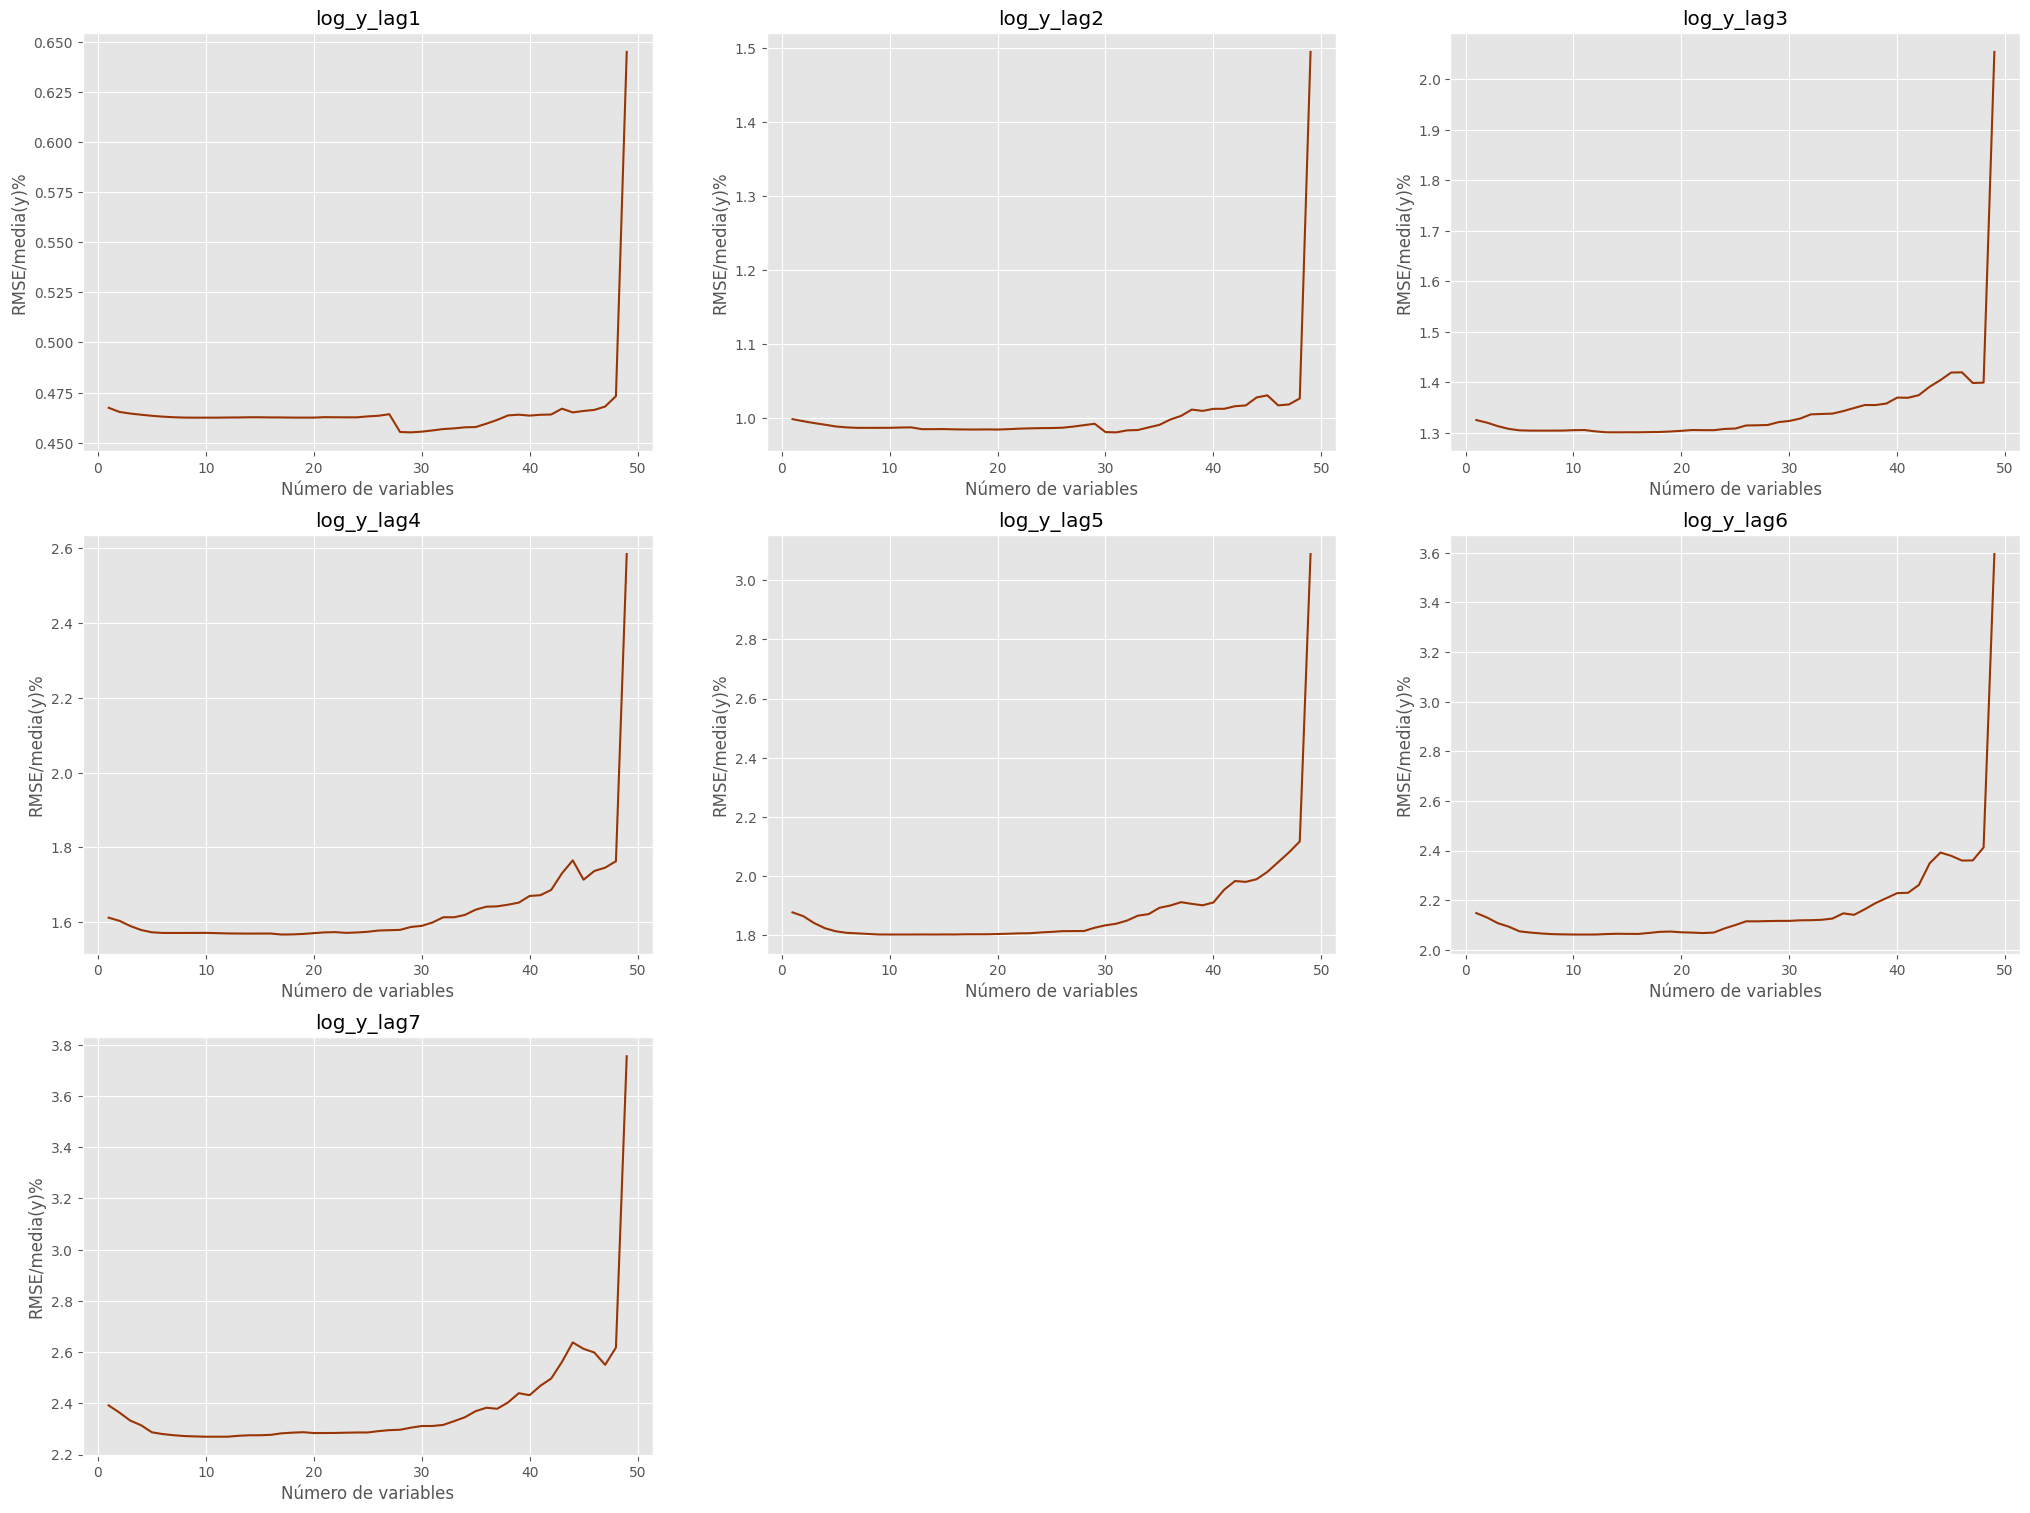

In [118]:
mpl.rcParams.update({'font.size': 10}) # set tamaño de ticks
# graficamos la performance según núm de variables para los 7 rezagos (sacando el término constante para mejorar la visualización)
fig=plt.figure(figsize=(25,25))
for i in range(0,7):
    ax=fig.add_subplot(4,3, i+1)
    ax.plot(output_dict[f'log_y_lag{i+1}'].loc[1:,'rmse'], color='#993404') # sacamos la constante para mejorar la visibilidad
    plt.title(f'log_y_lag{i+1}')
    plt.ylabel("RMSE/media(y)%")
    plt.xlabel("Número de variables")

Como se puede observar en los gráficos de arriba, la selección muestra que el error de predicción según número de variables (sacando la constante) tiene una leve forma de U, donde las primeras variables seleccionadas disminuyen el error de predicción en validación, pero a medida que agregamos más variables el desempeño comienza a caer. Debido a esto, sería deseable quedarnos con un modelo con el primer subconjunto de variables, debido a que no sólo aumentaría la performance predictiva, sino también reduciríamos la complejidad del modelo. De esta forma, tomamos la lista de variables seleccionadas que genera el menor error de predicción en cada uno de los targets bajo estudio y evaluamos la performance en test.

In [119]:
# lista donde guardamos los resultados de cada modelo óptimo
results_reg_test_df = []
for i in range(0,7):
    # mejores variables
    output_df = output_dict[f'log_y_lag{i+1}']
    idx=output_df[output_df.rmse == output_df.rmse.min()].index.item()
    best_vars = output_df.loc[1:idx,'var']
    best_vars = ['const'] + list(best_vars)
    # nuevo subconjunto de train
    train_best = x_train.loc[:, best_vars]
    test_best = x_test.loc[:, best_vars]
    # corremos la regresión
    best_model = sm.OLS(y_train.loc[:,f'log_y_lag{i+1}'], train_best.astype(float)).fit()
    # computamos el predicho en test
    predictions_best = best_model.predict(test_best)
    mse_best = mean_squared_error(y_test.loc[:,f'log_y_lag{i+1}'], 
                                predictions_best)
    rmse_best = math.sqrt(mse_best)
    mean_target_test = y_test.loc[:,f'log_y_lag{i+1}'].mean()
    rmse_mean = round(rmse_best/mean_target_test*100, 2)
    print(f'La predicción del log_y_lag{i+1} arroja un error del {style.green}{round(rmse_mean, 2)}%{style.endc} en test')
    # apilamos en la lista de resultados
    results_reg_test_df = results_reg_test_df + [rmse_mean]

La predicción del log_y_lag1 arroja un error del 0.34% en test
La predicción del log_y_lag2 arroja un error del 0.77% en test
La predicción del log_y_lag3 arroja un error del 0.99% en test
La predicción del log_y_lag4 arroja un error del 1.19% en test
La predicción del log_y_lag5 arroja un error del 1.44% en test
La predicción del log_y_lag6 arroja un error del 1.53% en test
La predicción del log_y_lag7 arroja un error del 1.74% en test


In [120]:
reg_result_best = pd.DataFrame(results_reg_test_df , columns=['reg_error']) 
reg_result_best

,reg_error
0,0.34
1,0.77
2,0.99
3,1.19
4,1.44
5,1.53
6,1.74


#### Regresión lineal con PCA

##### Principal Component Analysis (PCA)
Al momento de realizar una predicción, es posible que cuanta más y mejor información tengamos, más acertada sea. Sin embargo, el tiempo de ejecución del algoritmo que se esté utilizando (como regresión lineal) empezará a ser cada vez mayor y se utilizarán más recursos computacionales. 

Algo que hemos visto es que hay variables que son menos importantes que otras y que no aportan valor significativo a la predicción.

Si se quitan esas variables, se están reduciendo las dimensiones a trabajar, lo que implica menor cantidad de relaciones entre variables a considerar. 

De todos modos, no sería la mejor estrategia eliminar directamente las columnas del dataframe con las variables que consideremos menos importantes, porque podríamos estar equivocándonos. Si tenemos N variables, lo ideal es generar N nuevas variables que sean una combinación de las N variables antiguas y ordenarlas de mayor importancia a menor. De esta forma, podremos quedarnos con las variables con mayor importancia y descartar las de menor importancia. Así, estamos teniendo en cuenta a todas las variables antiguas sin tener que eliminar alguna, ya que las variables nuevas, como se explicó antes, son una combinación de las antiguas.

Sin ser por la parte de seleccionar cuántas variables utilizar de las mejores rankeadas, PCA se encarga de realizar la tarea.

Para la selección, lo mejor es graficar la "proporción de variación explicada" en formato scree plot y observar en qué parte del gráfico se ve una caída. Hasta esa variable será la que se tendrá en cuenta para la predicción.

PCA entonces arma una nueva base con las componentes principales más significativas. Si con las componentes principales obtengo 85%, me quedo con esas.

Sin embargo, no siempre PCA junto con regresión lineal, como se utilizará en este caso, tiene buenos resultados. Puede suceder que la regresión lineal por sí sola prediga mejor el comportamiento que agregando PCA.

A continuación se estudiará la regresión lineal con PCA y se analizarán los resultados.

In [121]:
# quitamos algunas variable que tienen alta correlación con otras variables para mejorar la predicción
train_aux = train.drop(['cryptocurrency_adjusted_log', 'ethereum_adjusted_log', 'bitcoin_adjusted_log', 'var_price_btc', 'cryptocurrency_top_adjusted_log', 'ethereum_top_adjusted_log', 'exchange_top_adjusted_log', 'bitcoin_top_adjusted_log'], axis = 1)
test_aux = test.drop(['cryptocurrency_adjusted_log', 'ethereum_adjusted_log', 'bitcoin_adjusted_log', 'var_price_btc', 'cryptocurrency_top_adjusted_log', 'ethereum_top_adjusted_log', 'exchange_top_adjusted_log', 'bitcoin_top_adjusted_log'], axis = 1)

In [123]:
#normalizamos los datos
scaler=StandardScaler()
scaler.fit(train_aux)
scaler.fit(test_aux)
X_scaled_train=scaler.transform(train_aux)# escalo los datos y los normalizo
X_scaled_test=scaler.transform(test_aux)

In [124]:
#Instanciamos objeto PCA y aplicamos
pca=PCA(n_components=len(train_aux.columns)) # Otra opción es instanciar pca sólo con dimensiones nuevas hasta obtener un mínimo "explicado" ej.: pca=PCA(.85)
pca.fit(X_scaled_train) # obtener los componentes principales
X_pca_train=pd.DataFrame(pca.transform(X_scaled_train), index = train_aux.index) # convertimos nuestros datos con las nuevas dimensiones de PCA

pca.fit(X_scaled_test) # obtener los componentes principales
X_pca_test=pd.DataFrame(pca.transform(X_scaled_test), index = test_aux.index) # convertimos nuestros datos con las nuevas dimensiones de PCA
 
#print("shape of X_pca_train", X_pca_train.shape)
#print("shape of X_pca_test", X_pca_test.shape)

expl = pca.explained_variance_ratio_
print(expl)

print('suma:',sum(expl[0:9]))
#Vemos que con 9 componentes tenemos algo mas del 85% de varianza explicada
#que el código elija la cantidad de componentes para que la suma sea lo más
#cercana a 85%

[2.68015338e-01 2.10323892e-01 1.25393409e-01 8.31587451e-02
 5.01142756e-02 4.36964474e-02 3.54970741e-02 2.89418879e-02
 2.37872466e-02 2.07242502e-02 1.62721868e-02 1.29247943e-02
 1.25916334e-02 9.59511177e-03 8.59140342e-03 6.72552644e-03
 5.50048606e-03 4.76120474e-03 4.66824372e-03 4.20332495e-03
 4.02153542e-03 3.42725101e-03 3.02668797e-03 2.36551763e-03
 2.28847211e-03 1.74721322e-03 1.40408675e-03 1.22304427e-03
 1.13302007e-03 1.00529390e-03 7.67123935e-04 6.33150289e-04
 4.43430057e-04 2.95629234e-04 2.57041503e-04 2.47411372e-04
 1.62320767e-04 6.44385353e-05 8.49151038e-07 1.55659750e-33
 1.55659750e-33]
suma: 0.8689283169635245


In [125]:
X_pca_train.shape #este es el nuevo dataset

(1956, 41)

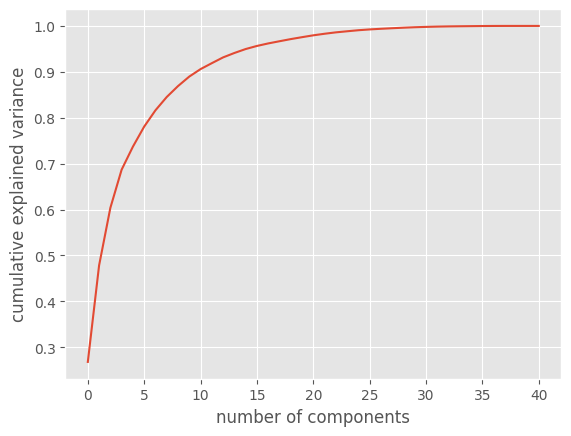

In [126]:
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [127]:
#Reducimos la cantidad de columnas para quedarnos con las primeras 9
df_pca_train = pd.DataFrame(X_pca_train).iloc[:,0:9]
df_pca_test = pd.DataFrame(X_pca_test).iloc[:,0:9]

In [128]:
X_pca_train

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-17,37.753555,2.448242,-1.178069,2.469408,2.875443,-0.537487,2.852596,-6.865120,0.775624,0.196495,...,0.326714,-0.031668,-0.215528,0.105192,-0.121756,0.032397,0.043540,-0.277491,-0.073038,0.173788
2015-08-18,37.767543,2.021114,-0.777946,2.450451,2.612177,-0.940543,3.054125,-0.088411,1.421204,0.009701,...,-0.157232,0.008086,0.380810,0.253470,-0.208973,0.038935,0.001173,0.146713,0.016311,0.002400
2015-08-19,37.741452,1.592335,0.048710,1.493281,2.345738,-0.149623,1.749212,2.895008,0.869569,0.130889,...,0.039946,0.086334,0.039853,0.112084,-0.176386,0.169110,0.053681,0.109180,-0.023383,-0.082983
2015-08-20,37.918453,1.730751,0.310789,1.849279,2.792300,-0.251898,0.842351,-6.107942,0.286096,0.522797,...,0.267362,-0.149100,-0.055121,0.121550,-0.159225,-0.034167,-0.093273,-0.056665,-0.053071,0.155276
2015-08-21,38.023057,2.076397,1.023587,2.202003,2.265197,-1.959190,0.779625,2.546722,1.180800,0.402599,...,-0.353685,-0.382725,0.331525,-0.039624,-0.049111,-0.136344,0.071372,0.165394,-0.026841,-0.021492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,-28.724707,5.131554,-5.099834,-4.630073,1.485604,-0.780903,-1.881754,-1.519702,1.539570,0.315943,...,0.050641,0.111975,0.035715,0.120967,0.114794,0.180544,-0.099698,-0.088562,-0.092971,-0.033718
2020-12-28,-29.241444,6.147362,-2.235645,-2.761617,0.071644,-0.159345,-0.914726,-1.461126,1.667396,0.067450,...,0.106130,0.120126,-0.026404,0.202380,0.082373,-0.047547,0.085952,0.147940,-0.039475,0.006214
2020-12-29,-29.580330,6.024946,-2.177924,-2.676149,-0.093651,0.031124,-0.338080,-0.239105,1.583923,-0.213503,...,0.130263,0.119752,0.212128,0.082030,0.191379,-0.028578,-0.053235,0.019647,-0.069416,0.015126


##### Entrenamiento del modelo con Regresión Lineal

In [129]:
df_pca_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1956 entries, 2015-08-17 to 2020-12-31
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1956 non-null   float64
 1   1       1956 non-null   float64
 2   2       1956 non-null   float64
 3   3       1956 non-null   float64
 4   4       1956 non-null   float64
 5   5       1956 non-null   float64
 6   6       1956 non-null   float64
 7   7       1956 non-null   float64
 8   8       1956 non-null   float64
dtypes: float64(9)
memory usage: 217.4+ KB


In [130]:
#agregar constante
x_train_pca = sm.add_constant(df_pca_train)
x_test_pca = sm.add_constant(df_pca_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [131]:
# ajuste lineal
model = sm.OLS(y_train.iloc[:,0], x_train_pca).fit()
 
# view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_y_lag1   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.589e+05
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:02:47   Log-Likelihood:                 4661.6
No. Observations:                1956   AIC:                            -9303.
Df Residuals:                    1946   BIC:                            -9247.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9527      0.001   3858.867      0.0

In [132]:
r_squaredAdj = []
for i in range(1,len(y_train.columns)+1):
  model = sm.OLS(y_train.loc[:,f'log_y_lag{i}'], x_train_pca).fit()
  r_squaredAdj = r_squaredAdj + [round(model.rsquared, 4)] 

In [133]:
r_squaredAdj

[0.9992, 0.9982, 0.9973, 0.9963, 0.9953, 0.9942, 0.9932]

##### Evaluación de performance

In [134]:
# computamos el predicho para cada uno de los rezagos de la dependiente
predictions_dict = {}
for i in range(1,len(y_train.columns)+1):
  model = sm.OLS(y_train.loc[:,f'log_y_lag{i}'], x_train_pca).fit()
  predictions = model.predict()
  predictions_dict[f'pred_y_lag{i}'] = predictions

In [135]:
#calculamos error de predicción para el conjunto train
for i in range(1,len(y_train.columns)+1):
  mse = mean_squared_error(y_train.loc[:,f'log_y_lag{i}'], 
                           predictions_dict[f'pred_y_lag{i}'])
  rmse = math.sqrt(mse)
  mean_target_train = y_train.loc[:,f'log_y_lag{i}'].mean()
  print(f'La predicción del log_y_lag{i+1} arroja un error del {style.green}{round(rmse/mean_target_train*100)}%{style.endc} en train')

La predicción del log_y_lag2 arroja un error del 1% en train
La predicción del log_y_lag3 arroja un error del 2% en train
La predicción del log_y_lag4 arroja un error del 2% en train
La predicción del log_y_lag5 arroja un error del 2% en train
La predicción del log_y_lag6 arroja un error del 3% en train
La predicción del log_y_lag7 arroja un error del 3% en train
La predicción del log_y_lag8 arroja un error del 3% en train


Se observa que para el conjunto train el error de predicción no sobrepasa el 3%, incluso para una predicción de 7 días hacia adelante. El menor error de predicción lo tiene para la target 'log_y_lag1', como es de esperarse. De todos modos, estos errores son mayores a los obtenidos al aplicar simplemente regresión lineal.

In [136]:
# computamos el predicho para cada uno de los rezagos de la dependiente, en este 
#caso para el grupo test
predictions_test_dict = {}
for i in range(1,len(y_test.columns)+1):
  model = sm.OLS(y_train.loc[:,f'log_y_lag{i}'], x_train_pca).fit()
  predictions = model.predict(x_test_pca)
  predictions_test_dict[f'pred_y_lag{i}'] = predictions

In [137]:
#calculamos error de predicción para el conjunto test
for i in range(1,len(y_test.columns)+1):
  mse = mean_squared_error(y_test.loc[:,f'log_y_lag{i}'], 
                           predictions_test_dict[f'pred_y_lag{i}'])
  rmse = math.sqrt(mse)
  mean_target_test = y_test.loc[:,f'log_y_lag{i}'].mean()
  print(f'La predicción del log_y_lag{i+1} arroja un error del {style.green}{round(rmse/mean_target_test*100)}%{style.endc} en test')

La predicción del log_y_lag2 arroja un error del 44% en test
La predicción del log_y_lag3 arroja un error del 44% en test
La predicción del log_y_lag4 arroja un error del 43% en test
La predicción del log_y_lag5 arroja un error del 43% en test
La predicción del log_y_lag6 arroja un error del 43% en test
La predicción del log_y_lag7 arroja un error del 43% en test
La predicción del log_y_lag8 arroja un error del 43% en test


El error de predicción en el grupo test es de entre 44% y 43%. 
Este error es mucho mayor que el obtenido al aplicar simplemente regresión lineal, sin PCA y se debe a que la variación del precio de ethereum desde el comienzo hasta la fecha es muy grande, por lo que existen valores outliers que llevan al mal funcionamiento de este modelo. A pesar de haber quitado variables que están muy correlacionadas entre sí, este error no disminuye.

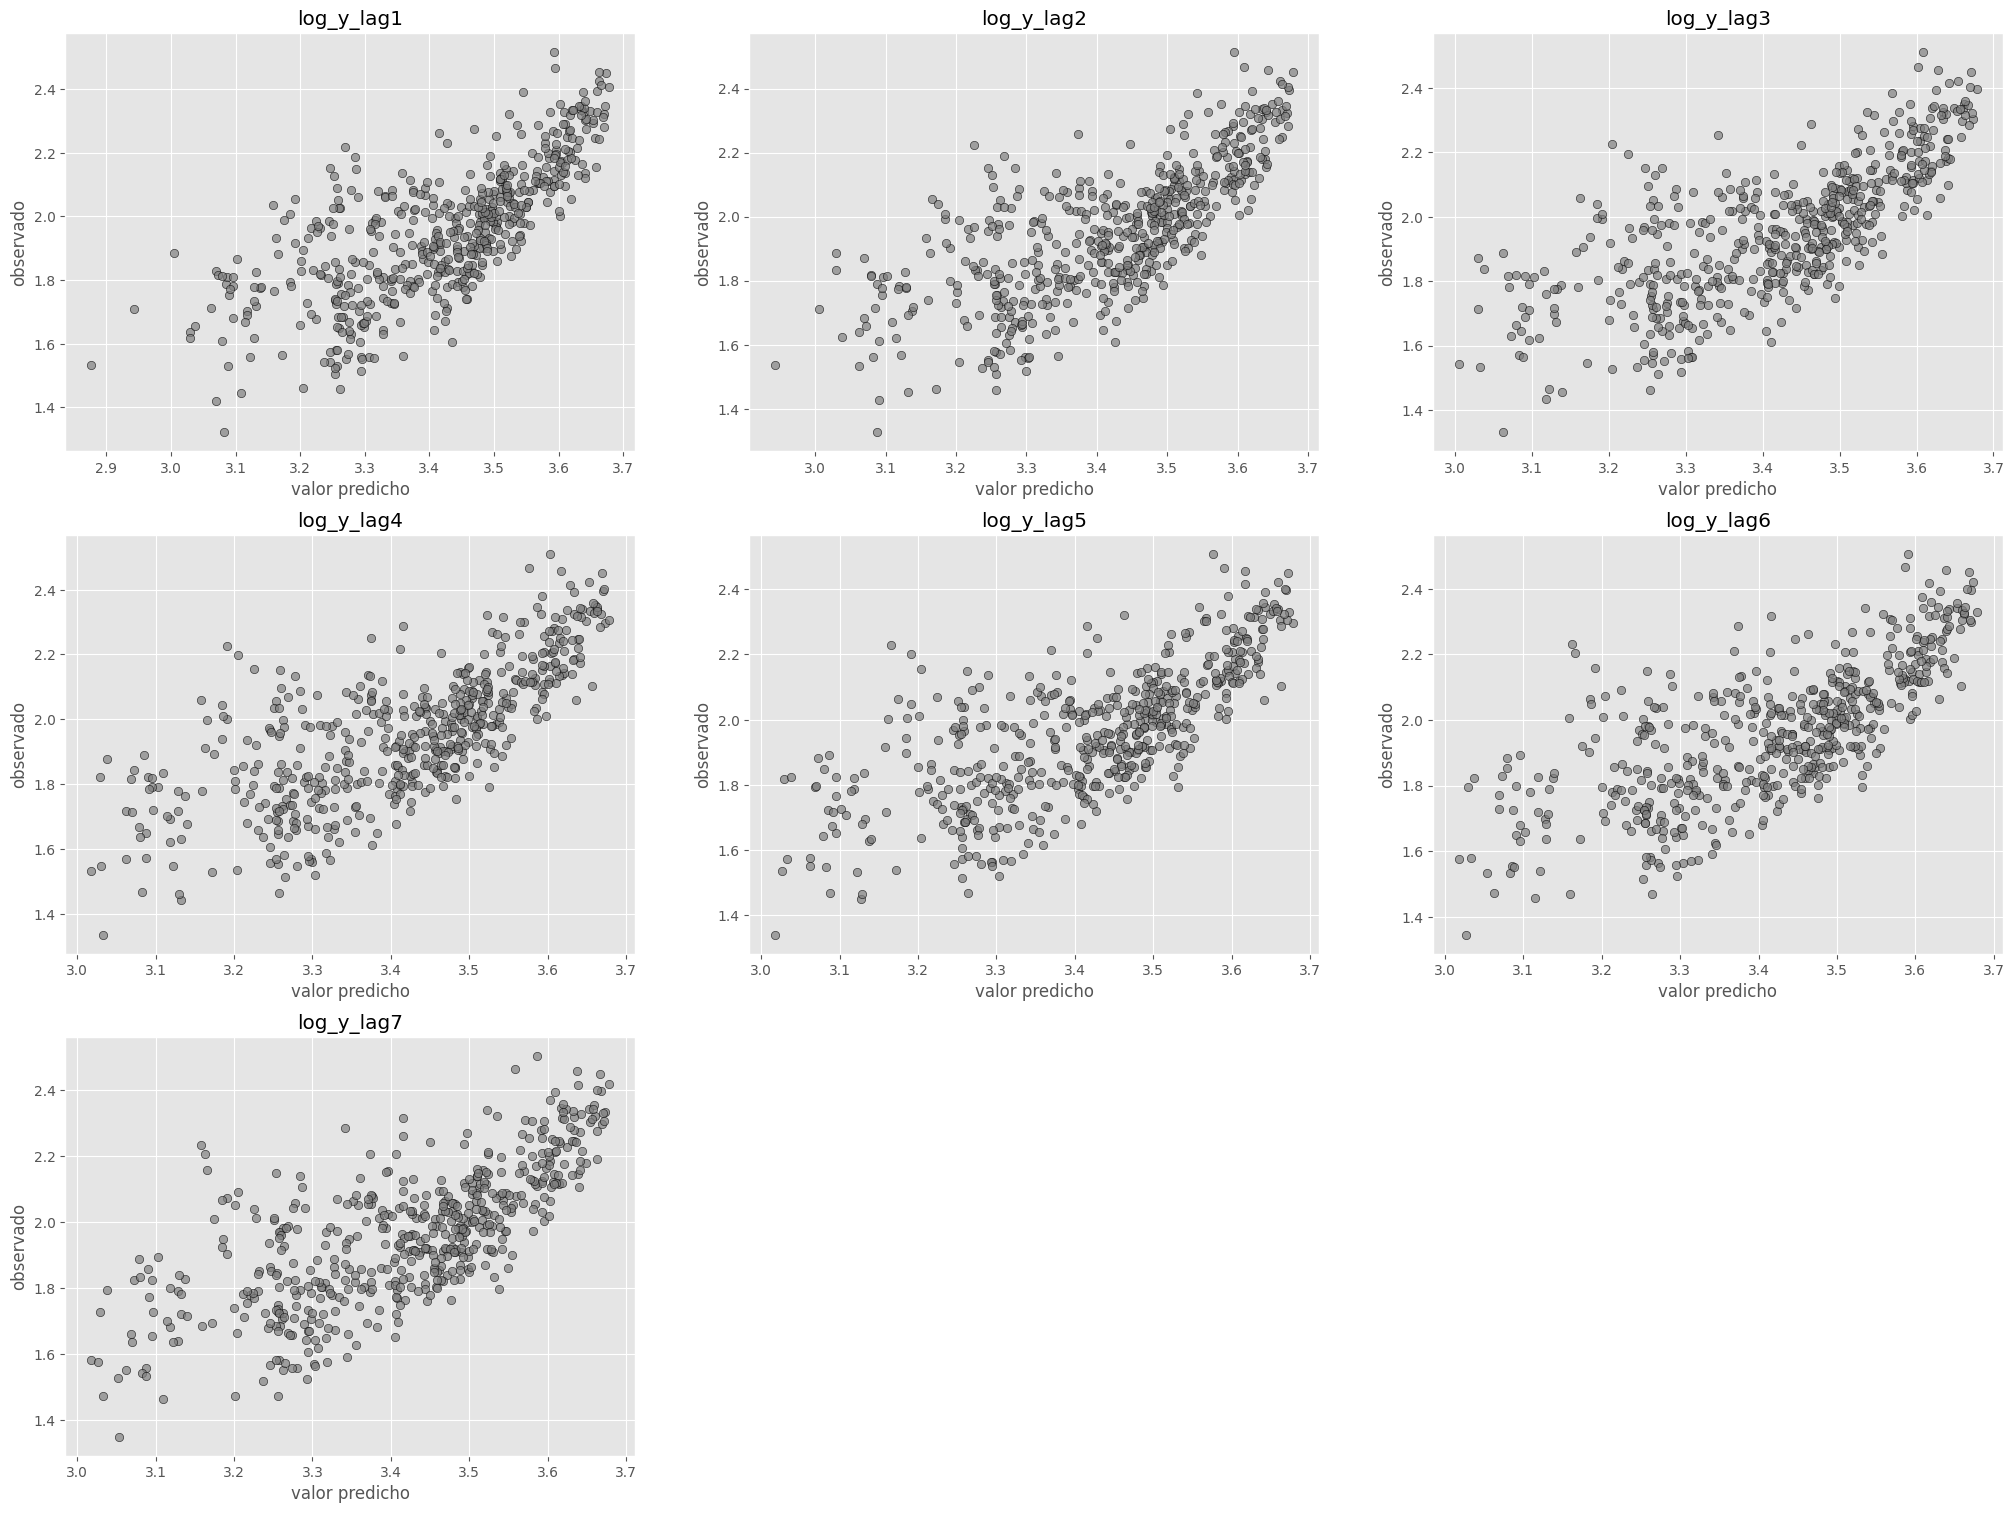

In [36]:
plt.style.use('default')
plt.style.use('ggplot')

fig=plt.figure(figsize=(25,25))
for i in range(0,7):
    ax=fig.add_subplot(4,3, i+1)
    ax.scatter(y_test.loc[:,f'log_y_lag{i+1}'], 
               predictions_test_dict[f'pred_y_lag{i+1}'], 
               edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
    plt.title(f'log_y_lag{i+1}')
    plt.xlabel("valor predicho")
    plt.ylabel("observado")

### Xgboost

#### Random search
Para realizar las estimaciones con xgboost creamos la función custom `xgb_ts()` utilizando como inputs las funciones de la librería `xgboost` para poder encontrar el mejor modelo para cada target a través de una búsqueda aleatoria de hiperparámetros combinado con la técnica de time series cross-validation. La idea detrás de `xgb_ts()` es realizar el mismo ejercicio de validación cruzada realizado en la regresión lineal pero para cada combinación de hiperparámetros establecida previamente. La función arrojará como output la performance los modelos de cada combinación de hiperparámetros generada, y con esa tabla podremos encontrar aquel de mejor performance con el que podremos evaluarlo en el grupo test. 

In [ ]:
#### XGBOOST time series function
def xgb_ts(train, y_train, n_estimator = [300, 500],
            max_depth_input = range(6,20),
            learning_rate_input = np.linspace(0.001, 0.1),
            gamma = np.linspace(0, 1),
            min_child_weight = range(1,20),
            subsample_input = np.linspace(0.1, 1),
            colsample_bytree_input = np.linspace(0.1, 1), 
            colsample_bylevel_input = np.linspace(0.1,1),
            folds = 10,
            n_grid = 100):
    ###### función para separar los grupos según intervalos de tiempo
    def date_range(start, end, intv):
        start = datetime.strptime(start,"%Y-%m-%d")
        end = datetime.strptime(end,"%Y-%m-%d")
        diff = (end  - start ) / intv
        for i in range(intv):
            yield (start + diff * i).strftime("%Y-%m-%d")
        yield end.strftime("%Y-%m-%d")
    #### 1. generación de hiperparámetros
    # dict
    n_grid = n_grid + 1
    random_search_list = pd.DataFrame({'max_depth':choices(list(max_depth_input), k=n_grid), 'learning_rate': choices(learning_rate_input, k=n_grid), 
                                       'gamma': choices(list(gamma), k=n_grid),'min_child_weight': choices(list(min_child_weight), k=n_grid),
                                       'subsample':choices(subsample_input, k=n_grid), 'colsample_bytree':choices(list(colsample_bytree_input), k=n_grid),
                                       'colsample_bylevel':choices(colsample_bylevel_input, k=n_grid), 'n_estimator':choices(n_estimator, k=n_grid)})

    #### 2. Iteración sobre la lista de hiperparámetros
    result_table_splitCV = pd.DataFrame() # input donde ponemos los resultados generales
    # print cross-validation approach in time series 
    print(f'{style.underline} Time Series Split {folds}-Cross-Validation {style.endc}')  
    for c in range(len(random_search_list.index)):
        ##### 2.1 seteo regresión xgboost 
        ## Ajustamos un modelo xgboost con una combinación de hiperparámetros
        xgbr = xgb.XGBRegressor(objective ='reg:squarederror', 
                                max_depth = random_search_list.max_depth[c],
                                learning_rate = random_search_list.learning_rate[c],
                                gamma = random_search_list.gamma[c],
                                min_child_weight = random_search_list.min_child_weight[c],
                                subsample = random_search_list.subsample[c],
                                colsample_bytree = random_search_list.colsample_bytree[c],
                                colsample_bylevel = random_search_list.colsample_bylevel[c],
                                n_estimators = random_search_list.n_estimator[c])
        ##### 2.2 Time Series Split Cross-Validation
        # armamos los grupos
        lower = train.index[0]
        upper = train.index[-1]
        timelist = list(date_range(lower, upper, folds+1))
        # iteración sobre los grupos armados
        rmse_mean_table = []  # input para poner resultados de performance en cada fold
        for i in range(1, len(timelist)-1):
            # intervalo de tiempo para las iteraciones
            first = timelist[0] # fecha inicial train
            last = timelist[i] # fecha final train
            aux = datetime.strptime(last,"%Y-%m-%d") + timedelta(days=1)
            first_valid = aux.strftime("%Y-%m-%d") # fecha inicial valid
            last_valid = timelist[i+1] # fecha inicial valid
            # formamos las bases train y validación
            x_train_cv = train[first:last]
            x_valid_cv = train[first_valid:last_valid]
            y_train_cv = y_train[first:last]
            y_valid_cv = y_train[first_valid:last_valid]
            xgbr.fit(x_train_cv, y_train_cv)
            ## predecimos en validación 
            ypred = xgbr.predict(x_valid_cv)
            mse = mean_squared_error(y_valid_cv, ypred)
            rmse_mean = round((mse**(1/2.0)/y_valid_cv.mean())*100) 
            rmse_mean_table = rmse_mean_table + [rmse_mean] 
        # Generamos dataframe de hiperparámetros utilizados + resultados de performance
        hyperpar_input =  pd.DataFrame({'max_depth':random_search_list.max_depth[c],
                                        'learning_rate': random_search_list.learning_rate[c],
                                        'gamma': random_search_list.gamma[c],
                                        'min_child_weight': random_search_list.min_child_weight[c],
                                        'subsample':random_search_list.subsample[c],
                                        'colsample_bytree':random_search_list.colsample_bytree[c],
                                        'colsample_bylevel':random_search_list.colsample_bylevel[c],
                                        'n_estimators':random_search_list.n_estimator[c]}, index = [c]) # 0 representa la fila de hiperparámetros a utilizar en la iteración
        hyperpar_input.reset_index(drop=True, inplace=True)
        mean_folds = sum(rmse_mean_table)/len(rmse_mean_table)
        rmse_mean_table = pd.DataFrame(rmse_mean_table).transpose()
        rmse_mean_table.reset_index(drop=True, inplace=True)
        result_table_splitCV = result_table_splitCV.append(pd.concat([hyperpar_input, rmse_mean_table, pd.Series(mean_folds)], axis=1, ignore_index=True))   
        print(f'Model {c} - max_depth: {style.green}{random_search_list.max_depth[c]}{style.endc}, ', end = ' ') 
        print(f'learning_rate: {style.green}{round(random_search_list.learning_rate[c], 2)}{style.endc},', end = ' ') 
        print(f'gamma: {style.green}{round(random_search_list.gamma[c], 2)}{style.endc},', end = ' ')
        print(f'min_child_weight: {style.green}{round(random_search_list.min_child_weight[c], 2)}{style.endc},', end = ' ')  
        print(f'subsample: {style.green}{round(random_search_list.subsample[c], 2)}{style.endc}, ', end = ' ') 
        print(f'colsample_bytree: {style.green}{round(random_search_list.colsample_bytree[c], 2)}{style.endc}', end=' ') 
        print(f'colsample_bylevel: {style.green}{round(random_search_list.colsample_bylevel[c], 2)}{style.endc}, ', end = ' ') 
        print(f'n_estimators: {style.green}{random_search_list.n_estimator[c]}{style.endc}, mean_folds_error: {style.green}{round(mean_folds)}%{style.endc} of the target mean in validation set')
    # output
    fold = [f'fold_{i}' for i in range(folds)]
    colnames = ['max_depth', 'learning_rate', 'gamma', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'n_estimators'] + fold + ['mean_folds_error']  
    result_table_splitCV.columns = colnames
    result_table_splitCV = result_table_splitCV.sort_values(by=['mean_folds_error'])
    result_table_splitCV = result_table_splitCV.reset_index(drop=True)
    return result_table_splitCV 

In [ ]:
xgb_results_dict = {}
for i in range(1,len(y_train.columns)+1):
    print(f'{style.green}{i}. Iteration over log_y_lag{i}{style.endc}')
    x = xgb_ts(train, y_train.loc[:,f'log_y_lag{i}'], n_grid = 20, folds = 10,  
               n_estimator = [900, 700], max_depth_input = range(15, 30), gamma=np.linspace(0,0.001))
    xgb_results_dict[f'log_y_lag{i}'] = x
del x

1. Iteration over log_y_lag1
 Time Series Split 10-Cross-Validation 
Model 0 - max_depth: 29,  learning_rate: 0.1, gamma: 0.0, min_child_weight: 3, subsample: 0.72,  colsample_bytree: 0.93 colsample_bylevel: 0.89,  n_estimators: 900, mean_folds_error: 9% of the target mean in validation set
Model 1 - max_depth: 25,  learning_rate: 0.07, gamma: 0.0, min_child_weight: 3, subsample: 0.65,  colsample_bytree: 0.27 colsample_bylevel: 0.93,  n_estimators: 900, mean_folds_error: 12% of the target mean in validation set
Model 2 - max_depth: 15,  learning_rate: 0.03, gamma: 0.0, min_child_weight: 19, subsample: 0.27,  colsample_bytree: 0.96 colsample_bylevel: 0.98,  n_estimators: 900, mean_folds_error: 12% of the target mean in validation set
Model 3 - max_depth: 28,  learning_rate: 0.03, gamma: 0.0, min_child_weight: 11, subsample: 0.94,  colsample_bytree: 0.5 colsample_bylevel: 1.0,  n_estimators: 900, mean_folds_error: 11% of the target mean in validation set
Model 4 - max_depth: 19,  learnin

Una vez realizado la búsqueda de hiperparámetros guardamos los mejores resultados para predecir cada precio futuro.

In [ ]:
# guardamos solo los mejores resultados para cada lag
xgb_results_df = pd.DataFrame()
for i in range(1,len(y_train.columns)+1):
    xgb_results_df = xgb_results_df.append(xgb_results_dict[f'log_y_lag{i}'].iloc[0,0:8]) 
xgb_results_df = xgb_results_df.reset_index(drop=True)
xgb_results_df

,max_depth,learning_rate,gamma,min_child_weight,subsample,colsample_bytree,colsample_bylevel,n_estimators
0,29.0,0.100000,0.000939,3.0,0.724490,0.926531,0.889796,900.0
1,23.0,0.093939,0.000388,1.0,0.559184,0.742857,0.761224,900.0
2,18.0,0.021204,0.000980,2.0,0.577551,0.889796,0.834694,700.0
3,16.0,0.007061,0.000449,5.0,0.981633,0.724490,0.687755,900.0
4,16.0,0.047469,0.000327,3.0,0.191837,0.981633,0.816327,700.0
5,27.0,0.065653,0.000449,7.0,0.504082,0.834694,0.577551,900.0
6,16.0,0.079796,0.000204,11.0,0.944898,0.797959,0.742857,700.0


In [ ]:
xgb_results_df[['max_depth', 'min_child_weight', 'n_estimators']] = xgb_results_df[['max_depth', 'min_child_weight', 'n_estimators']].astype(int)
xgb_results_df

,max_depth,learning_rate,gamma,min_child_weight,subsample,colsample_bytree,colsample_bylevel,n_estimators
0,29,0.100000,0.000939,3,0.724490,0.926531,0.889796,900
1,23,0.093939,0.000388,1,0.559184,0.742857,0.761224,900
2,18,0.021204,0.000980,2,0.577551,0.889796,0.834694,700
3,16,0.007061,0.000449,5,0.981633,0.724490,0.687755,900
4,16,0.047469,0.000327,3,0.191837,0.981633,0.816327,700
5,27,0.065653,0.000449,7,0.504082,0.834694,0.577551,900
6,16,0.079796,0.000204,11,0.944898,0.797959,0.742857,700


In [ ]:
## evaluamos en test ajustando el mejor modelo en todo el subconjunto de train
results_xgb_test_df = []
for i in range(0,len(y_train.columns)):
    print(f'{style.underline}{i+1} - log_y_lag{i+1}{style.endc}:')
    xgbr_best = xgb.XGBRegressor(objective ='reg:squarederror', 
                                max_depth = xgb_results_df.max_depth[i],
                                learning_rate = xgb_results_df.learning_rate[i],
                                subsample = xgb_results_df.subsample[i],
                                colsample_bytree = xgb_results_df.colsample_bytree[i],
                                colsample_bylevel = xgb_results_df.colsample_bylevel[i],
                                n_estimators = xgb_results_df.n_estimators[i])
    xgbr_best.fit(train, y_train.loc[:,f'log_y_lag{i+1}'])
    ## predecimos en test
    ypred_best = xgbr_best.predict(test)
    mse = mean_squared_error(y_test.loc[:,f'log_y_lag{i+1}'], ypred_best)
    rmse_mean_best = round((mse**(1/2.0)/y_test.loc[:,f'log_y_lag{i+1}'].mean())*100)
    print(f'La predicción del mejor modelo validado de XGBoost arroja un error de predicción del {style.green}{round(rmse_mean_best)}%{style.endc} de la media del target en el subconjunto de test')
    results_xgb_test_df = results_xgb_test_df + [rmse_mean_best]

1 - log_y_lag1:
La predicción del mejor modelo validado de XGBoost arroja un error de predicción del 11% de la media del target en el subconjunto de test
2 - log_y_lag2:
La predicción del mejor modelo validado de XGBoost arroja un error de predicción del 13% de la media del target en el subconjunto de test
3 - log_y_lag3:
La predicción del mejor modelo validado de XGBoost arroja un error de predicción del 13% de la media del target en el subconjunto de test
4 - log_y_lag4:
La predicción del mejor modelo validado de XGBoost arroja un error de predicción del 14% de la media del target en el subconjunto de test
5 - log_y_lag5:
La predicción del mejor modelo validado de XGBoost arroja un error de predicción del 15% de la media del target en el subconjunto de test
6 - log_y_lag6:
La predicción del mejor modelo validado de XGBoost arroja un error de predicción del 15% de la media del target en el subconjunto de test
7 - log_y_lag7:
La predicción del mejor modelo validado de XGBoost arroja un

In [ ]:
# computamos el error de predicción para cada rezago
xgb_result_best = pd.DataFrame(results_xgb_test_df, columns=['xgb_error']) 
xgb_result_best 

,xgb_error
0,11
1,13
2,13
3,14
4,15
5,15
6,13
